In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import Libraries.dataloader as dl
from torchviz import make_dot
import random


import segmentation_models_pytorch as smp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

In [3]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(np.uint8(color_im))
    depth_raw = o3d.geometry.Image(np.float32(depth_im))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 10000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def CreateAxisCloud(depth_im):
    depth_raw  = o3d.geometry.Image(np.float32(depth_im/10)) # Converts depth data into image format
    PointCloud = o3d.geometry.PointCloud.create_from_depth_image(depth_raw,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,1,0]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [4]:
from Libraries.dataloader import DataLoader as DL

DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DL()

X_A, y_A = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'files/axis', 'S')
X_B, y_B = dl.load(DATASET_ROOTDIR, 'files_ArUco/data_ArUco.csv', 'files_ArUco/axis', 'S')

X_trainA, X_validationA, y_trainA, y_validationA = train_test_split(X_A, y_A, test_size=0.2, random_state=101)
X_trainB, X_validationB, y_trainB, y_validationB = train_test_split(X_B, y_B, test_size=0.03, random_state=101)

X_train = torch.cat((X_trainA, X_trainB),axis=0)
y_train = torch.cat((y_trainA, y_trainB),axis=0)

X_train_aug = X_train.clone()
for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
X_train = torch.cat((X_train, X_train_aug),axis=0)
y_train = torch.cat((y_train, y_train),axis=0)

X_validation = torch.cat((X_validationA, X_validationB),axis=0)
y_validation = torch.cat((y_validationA, y_validationB),axis=0)

In [20]:
# plt.figure()
# plt.imshow(X_train[5][0].cpu().detach().numpy(), cmap='gray')

# plt.figure()
# plt.imshow(y_validation[11][0].cpu().detach().numpy(),cmap='gray')

In [21]:
X_validation.shape

torch.Size([43, 3, 256, 320])

In [22]:
train_set = TensorDataset(X_train, y_train)
val_set = TensorDataset(X_validation, y_validation)

loader_args = dict(batch_size=6, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
train_loader = DataLoader(train_set,shuffle=True, **loader_args)
val_loader = DataLoader(val_set,shuffle=False, **loader_args)

In [23]:
# class AoRModel(nn.Module):
#     def __init__(self,pretrained=False ,input_channels=6, output_size=1):
#         super().__init__()
#         self.unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana',pretrained=False, scale=0.5)
#         self.unet.inc.double_conv[0] = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#         self.unet.outc.conv = nn.Conv2d(in_channels=64, out_channels=output_size, kernel_size=(1, 1), stride=(1, 1))
#     def forward(self, X):
#         return self.unet(X)

In [24]:
amp=False
device='cuda'

In [25]:
# Model = AoRModel().to(device)
# Model = UNet3D(n_channels=6, n_classes=1,trilinear=False).to(device)
Model = smp.Unet(in_channels=3, classes=1,encoder_weights=None,
                         encoder_name='timm-resnest50d').to(device)
print(Model)

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [26]:
# ModelCutter = AoRModel(input_channels=7).to(device)

In [27]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = F.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [28]:
criterion = smp.losses.DiceLoss(mode='binary')
# criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=10, min_lr=0.0000001)

In [29]:
epochs = 60

train_losses = []
validation_losses = []

Model.train()
for epoch in range(epochs):
    # Run the training batches
    for batch, (images, true_mask) in enumerate(train_loader):
        batch+=1
        
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        
        # Apply the model
        mask_prediction = Model(images)
        loss = criterion(mask_prediction, true_mask)
            
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if batch%1 == 0:
            print(f'epoch: {epoch+1:2}  batch: {batch}  loss: {loss.item():10.8f}')
    
    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
    
    # Run the validationing batches
    with torch.no_grad():
        for batch, (images, true_mask) in enumerate(val_loader):
            batch+=1

            images = images.to(device=device)
            true_mask = true_mask.to(device=device)

            # Apply the model
            mask_pred = Model(images)
            loss = criterion(mask_pred, true_mask)

    validation_losses.append(loss.cpu().detach().numpy())

epoch:  1  batch: 1  loss: 0.96221554
epoch:  1  batch: 2  loss: 0.96874982
epoch:  1  batch: 3  loss: 0.96548301
epoch:  1  batch: 4  loss: 0.94481719
epoch:  1  batch: 5  loss: 0.95637697
epoch:  1  batch: 6  loss: 0.97130221
epoch:  1  batch: 7  loss: 0.95758885
epoch:  1  batch: 8  loss: 0.94758683
epoch:  1  batch: 9  loss: 0.93137527
epoch:  1  batch: 10  loss: 0.96582365
epoch:  1  batch: 11  loss: 0.94252348
epoch:  1  batch: 12  loss: 0.95900053
epoch:  1  batch: 13  loss: 0.95300466
epoch:  1  batch: 14  loss: 0.94828993
epoch:  1  batch: 15  loss: 0.94122928
epoch:  1  batch: 16  loss: 0.94713730
epoch:  1  batch: 17  loss: 0.94530612
epoch:  1  batch: 18  loss: 0.95780623
epoch:  1  batch: 19  loss: 0.95510674
epoch:  1  batch: 20  loss: 0.95200747
epoch:  1  batch: 21  loss: 0.95504177
epoch:  1  batch: 22  loss: 0.91468561
epoch:  1  batch: 23  loss: 0.92039752
epoch:  1  batch: 24  loss: 0.93303621
epoch:  1  batch: 25  loss: 0.95572644
epoch:  1  batch: 26  loss: 0.9378

epoch:  2  batch: 43  loss: 0.87592202
epoch:  2  batch: 44  loss: 0.63572407
epoch:  2  batch: 45  loss: 0.69278705
epoch:  2  batch: 46  loss: 0.72690737
epoch:  2  batch: 47  loss: 0.68306720
epoch:  2  batch: 48  loss: 0.72117877
epoch:  2  batch: 49  loss: 0.88966531
epoch:  2  batch: 50  loss: 0.80516046
epoch:  2  batch: 51  loss: 0.55812579
epoch:  2  batch: 52  loss: 0.60517597
epoch:  2  batch: 53  loss: 0.82952082
epoch:  2  batch: 54  loss: 0.47313100
epoch:  2  batch: 55  loss: 0.51285064
epoch:  2  batch: 56  loss: 0.58617139
epoch:  2  batch: 57  loss: 0.56843019
epoch:  2  batch: 58  loss: 0.94580036
epoch:  2  batch: 59  loss: 0.50566614
epoch:  2  batch: 60  loss: 0.64440644
epoch:  2  batch: 61  loss: 0.73558748
epoch:  2  batch: 62  loss: 0.78351688
epoch:  2  batch: 63  loss: 0.49036974
epoch:  2  batch: 64  loss: 0.74703395
epoch:  2  batch: 65  loss: 0.52145195
epoch:  2  batch: 66  loss: 0.64839172
epoch:  2  batch: 67  loss: 0.73254746
epoch:  2  batch: 68  los

epoch:  3  batch: 85  loss: 0.53787315
epoch:  3  batch: 86  loss: 0.54417181
epoch:  3  batch: 87  loss: 0.62359178
epoch:  3  batch: 88  loss: 0.83018941
epoch:  3  batch: 89  loss: 0.69564831
epoch:  3  batch: 90  loss: 0.73640245
epoch:  3  batch: 91  loss: 0.59851706
epoch:  3  batch: 92  loss: 0.46453857
epoch:  3  batch: 93  loss: 0.93290949
epoch:  3  batch: 94  loss: 0.48374391
epoch:  3  batch: 95  loss: 0.63046956
epoch:  3  batch: 96  loss: 0.39110988
epoch:  3  batch: 97  loss: 0.64541537
epoch:  3  batch: 98  loss: 0.54255414
epoch:  3  batch: 99  loss: 0.45550835
epoch:  3  batch: 100  loss: 0.51386940
epoch:  3  batch: 101  loss: 0.60450077
epoch:  3  batch: 102  loss: 0.51919568
epoch:  3  batch: 103  loss: 0.42830169
epoch:  3  batch: 104  loss: 0.31062311
epoch:  3  batch: 105  loss: 0.56243157
epoch:  3  batch: 106  loss: 0.71319735
epoch:  3  batch: 107  loss: 0.56327784
epoch:  3  batch: 108  loss: 0.60847771
epoch:  3  batch: 109  loss: 0.44851899
epoch:  3  batc

epoch:  4  batch: 126  loss: 0.44535923
epoch:  4  batch: 127  loss: 0.44248116
epoch:  4  batch: 128  loss: 0.40013957
epoch:  4  batch: 129  loss: 0.55237734
epoch:  4  batch: 130  loss: 0.72950369
epoch:  4  batch: 131  loss: 0.41200256
epoch:  4  batch: 132  loss: 0.38891023
epoch:  4  batch: 133  loss: 0.56815237
epoch:  4  batch: 134  loss: 0.65459162
epoch:  4  batch: 135  loss: 0.42548567
epoch:  4  batch: 136  loss: 0.19109440
epoch:  4  batch: 137  loss: 0.47524750
epoch:  4  batch: 138  loss: 0.53451443
epoch:  4  batch: 139  loss: 0.20587438
epoch:  4  batch: 140  loss: 0.57178086
epoch:  4  batch: 141  loss: 0.58388400
epoch:  4  batch: 142  loss: 0.44728625
epoch:  4  batch: 143  loss: 0.85062045
epoch:  4  batch: 144  loss: 0.69123149
epoch:  4  batch: 145  loss: 0.35001254
epoch:  4  batch: 146  loss: 0.34103411
epoch:  4  batch: 147  loss: 0.17147219
epoch:  4  batch: 148  loss: 0.50321090
epoch:  4  batch: 149  loss: 0.30346376
epoch:  4  batch: 150  loss: 0.30022633


epoch:  5  batch: 167  loss: 0.46531570
epoch:  6  batch: 1  loss: 0.11099255
epoch:  6  batch: 2  loss: 0.49923575
epoch:  6  batch: 3  loss: 0.34032083
epoch:  6  batch: 4  loss: 0.23261476
epoch:  6  batch: 5  loss: 0.53863430
epoch:  6  batch: 6  loss: 0.39167351
epoch:  6  batch: 7  loss: 0.40695560
epoch:  6  batch: 8  loss: 0.56106114
epoch:  6  batch: 9  loss: 0.07542634
epoch:  6  batch: 10  loss: 0.50400090
epoch:  6  batch: 11  loss: 0.36651242
epoch:  6  batch: 12  loss: 0.43978894
epoch:  6  batch: 13  loss: 0.43489915
epoch:  6  batch: 14  loss: 0.15783197
epoch:  6  batch: 15  loss: 0.26616728
epoch:  6  batch: 16  loss: 0.33992720
epoch:  6  batch: 17  loss: 0.24399841
epoch:  6  batch: 18  loss: 0.49006122
epoch:  6  batch: 19  loss: 0.33997279
epoch:  6  batch: 20  loss: 0.57034373
epoch:  6  batch: 21  loss: 0.25675040
epoch:  6  batch: 22  loss: 0.24997491
epoch:  6  batch: 23  loss: 0.40690589
epoch:  6  batch: 24  loss: 0.25070637
epoch:  6  batch: 25  loss: 0.422

epoch:  7  batch: 42  loss: 0.44325852
epoch:  7  batch: 43  loss: 0.30379647
epoch:  7  batch: 44  loss: 0.46612555
epoch:  7  batch: 45  loss: 0.32288647
epoch:  7  batch: 46  loss: 0.31668144
epoch:  7  batch: 47  loss: 0.45471072
epoch:  7  batch: 48  loss: 0.33453614
epoch:  7  batch: 49  loss: 0.14506131
epoch:  7  batch: 50  loss: 0.25746542
epoch:  7  batch: 51  loss: 0.48775750
epoch:  7  batch: 52  loss: 0.57600105
epoch:  7  batch: 53  loss: 0.18676418
epoch:  7  batch: 54  loss: 0.18176645
epoch:  7  batch: 55  loss: 0.22628158
epoch:  7  batch: 56  loss: 0.36193526
epoch:  7  batch: 57  loss: 0.33105177
epoch:  7  batch: 58  loss: 0.35623252
epoch:  7  batch: 59  loss: 0.46033370
epoch:  7  batch: 60  loss: 0.26767164
epoch:  7  batch: 61  loss: 0.41574150
epoch:  7  batch: 62  loss: 0.04886103
epoch:  7  batch: 63  loss: 0.31086022
epoch:  7  batch: 64  loss: 0.03388959
epoch:  7  batch: 65  loss: 0.46538746
epoch:  7  batch: 66  loss: 0.15457481
epoch:  7  batch: 67  los

epoch:  8  batch: 84  loss: 0.38336867
epoch:  8  batch: 85  loss: 0.41208231
epoch:  8  batch: 86  loss: 0.23878932
epoch:  8  batch: 87  loss: 0.18601787
epoch:  8  batch: 88  loss: 0.40692317
epoch:  8  batch: 89  loss: 0.10660893
epoch:  8  batch: 90  loss: 0.44511086
epoch:  8  batch: 91  loss: 0.28900820
epoch:  8  batch: 92  loss: 0.35115314
epoch:  8  batch: 93  loss: 0.18593299
epoch:  8  batch: 94  loss: 0.69610113
epoch:  8  batch: 95  loss: -0.00152862
epoch:  8  batch: 96  loss: 0.25322014
epoch:  8  batch: 97  loss: 0.53626454
epoch:  8  batch: 98  loss: 0.00488299
epoch:  8  batch: 99  loss: 0.16011673
epoch:  8  batch: 100  loss: 0.44469339
epoch:  8  batch: 101  loss: 0.34791464
epoch:  8  batch: 102  loss: 0.12566394
epoch:  8  batch: 103  loss: 0.46907520
epoch:  8  batch: 104  loss: 0.34740961
epoch:  8  batch: 105  loss: 0.20467615
epoch:  8  batch: 106  loss: 0.60022312
epoch:  8  batch: 107  loss: 0.49086809
epoch:  8  batch: 108  loss: 0.26108396
epoch:  8  batc

epoch:  9  batch: 125  loss: 0.28116453
epoch:  9  batch: 126  loss: 0.34509796
epoch:  9  batch: 127  loss: -0.13630378
epoch:  9  batch: 128  loss: -0.02134943
epoch:  9  batch: 129  loss: 0.38890713
epoch:  9  batch: 130  loss: 0.01053727
epoch:  9  batch: 131  loss: 0.51872480
epoch:  9  batch: 132  loss: 0.02338707
epoch:  9  batch: 133  loss: 0.19897115
epoch:  9  batch: 134  loss: 0.31420177
epoch:  9  batch: 135  loss: 0.44567442
epoch:  9  batch: 136  loss: 0.10770220
epoch:  9  batch: 137  loss: 0.40906042
epoch:  9  batch: 138  loss: 0.23956412
epoch:  9  batch: 139  loss: 0.22313881
epoch:  9  batch: 140  loss: 0.15148556
epoch:  9  batch: 141  loss: 0.29722303
epoch:  9  batch: 142  loss: 0.24260539
epoch:  9  batch: 143  loss: 0.63019747
epoch:  9  batch: 144  loss: 0.14845318
epoch:  9  batch: 145  loss: 0.21680856
epoch:  9  batch: 146  loss: 0.22591090
epoch:  9  batch: 147  loss: 0.52481472
epoch:  9  batch: 148  loss: -0.01194036
epoch:  9  batch: 149  loss: 0.149430

epoch: 10  batch: 166  loss: 0.05417293
epoch: 10  batch: 167  loss: 0.27186292
epoch: 11  batch: 1  loss: -0.06983829
epoch: 11  batch: 2  loss: 0.26185256
epoch: 11  batch: 3  loss: 0.22896433
epoch: 11  batch: 4  loss: 0.18038172
epoch: 11  batch: 5  loss: 0.36841953
epoch: 11  batch: 6  loss: 0.04236305
epoch: 11  batch: 7  loss: 0.26725590
epoch: 11  batch: 8  loss: -0.07697916
epoch: 11  batch: 9  loss: 0.21289927
epoch: 11  batch: 10  loss: 0.02788025
epoch: 11  batch: 11  loss: 0.45684463
epoch: 11  batch: 12  loss: 0.15583986
epoch: 11  batch: 13  loss: 0.06230569
epoch: 11  batch: 14  loss: 0.08446068
epoch: 11  batch: 15  loss: 0.18365246
epoch: 11  batch: 16  loss: 0.25301141
epoch: 11  batch: 17  loss: 0.01318783
epoch: 11  batch: 18  loss: 0.11170536
epoch: 11  batch: 19  loss: 0.00788379
epoch: 11  batch: 20  loss: 0.30653971
epoch: 11  batch: 21  loss: 0.12714517
epoch: 11  batch: 22  loss: 0.30550879
epoch: 11  batch: 23  loss: 0.41449833
epoch: 11  batch: 24  loss: 0.

epoch: 12  batch: 40  loss: 0.03387046
epoch: 12  batch: 41  loss: 0.11735272
epoch: 12  batch: 42  loss: 0.37151444
epoch: 12  batch: 43  loss: -0.00145578
epoch: 12  batch: 44  loss: 0.10773659
epoch: 12  batch: 45  loss: 0.22561735
epoch: 12  batch: 46  loss: 0.22243428
epoch: 12  batch: 47  loss: 0.03668022
epoch: 12  batch: 48  loss: 0.10939848
epoch: 12  batch: 49  loss: 0.17155588
epoch: 12  batch: 50  loss: 0.22907275
epoch: 12  batch: 51  loss: 0.24601752
epoch: 12  batch: 52  loss: 0.25132060
epoch: 12  batch: 53  loss: 0.28243488
epoch: 12  batch: 54  loss: 0.26540977
epoch: 12  batch: 55  loss: 0.11713123
epoch: 12  batch: 56  loss: 0.21994656
epoch: 12  batch: 57  loss: -0.02977610
epoch: 12  batch: 58  loss: 0.03461289
epoch: 12  batch: 59  loss: 0.04607755
epoch: 12  batch: 60  loss: 0.43891764
epoch: 12  batch: 61  loss: 0.26434302
epoch: 12  batch: 62  loss: 0.01053250
epoch: 12  batch: 63  loss: -0.04401541
epoch: 12  batch: 64  loss: 0.09964919
epoch: 12  batch: 65  

epoch: 13  batch: 81  loss: 0.08415759
epoch: 13  batch: 82  loss: 0.26824504
epoch: 13  batch: 83  loss: -0.01736224
epoch: 13  batch: 84  loss: 0.24290448
epoch: 13  batch: 85  loss: 0.12826574
epoch: 13  batch: 86  loss: 0.00825256
epoch: 13  batch: 87  loss: 0.07101560
epoch: 13  batch: 88  loss: -0.02200222
epoch: 13  batch: 89  loss: -0.10512257
epoch: 13  batch: 90  loss: -0.04299736
epoch: 13  batch: 91  loss: 0.05368948
epoch: 13  batch: 92  loss: -0.03329194
epoch: 13  batch: 93  loss: -0.05247033
epoch: 13  batch: 94  loss: 0.18826836
epoch: 13  batch: 95  loss: 0.28774923
epoch: 13  batch: 96  loss: 0.02207798
epoch: 13  batch: 97  loss: 0.36953336
epoch: 13  batch: 98  loss: 0.12298667
epoch: 13  batch: 99  loss: 0.70161808
epoch: 13  batch: 100  loss: 0.11340272
epoch: 13  batch: 101  loss: 0.01693571
epoch: 13  batch: 102  loss: 0.14821494
epoch: 13  batch: 103  loss: 0.43656099
epoch: 13  batch: 104  loss: -0.01090443
epoch: 13  batch: 105  loss: 0.20244020
epoch: 13  b

epoch: 14  batch: 121  loss: -0.09276187
epoch: 14  batch: 122  loss: -0.22078693
epoch: 14  batch: 123  loss: 0.13627857
epoch: 14  batch: 124  loss: 0.09005499
epoch: 14  batch: 125  loss: 0.47691095
epoch: 14  batch: 126  loss: 0.10381550
epoch: 14  batch: 127  loss: -0.03059506
epoch: 14  batch: 128  loss: -0.02842307
epoch: 14  batch: 129  loss: 0.22562546
epoch: 14  batch: 130  loss: -0.04978108
epoch: 14  batch: 131  loss: 0.59444702
epoch: 14  batch: 132  loss: -0.07895684
epoch: 14  batch: 133  loss: 0.17108440
epoch: 14  batch: 134  loss: 0.34970307
epoch: 14  batch: 135  loss: 0.25496924
epoch: 14  batch: 136  loss: 0.03689307
epoch: 14  batch: 137  loss: 0.00823742
epoch: 14  batch: 138  loss: -0.07842481
epoch: 14  batch: 139  loss: 0.01803815
epoch: 14  batch: 140  loss: 0.07077807
epoch: 14  batch: 141  loss: 0.53244305
epoch: 14  batch: 142  loss: -0.06545007
epoch: 14  batch: 143  loss: 0.11432236
epoch: 14  batch: 144  loss: 0.17844641
epoch: 14  batch: 145  loss: -0.

epoch: 15  batch: 160  loss: -0.00085676
epoch: 15  batch: 161  loss: 0.02060491
epoch: 15  batch: 162  loss: 0.54580033
epoch: 15  batch: 163  loss: 0.04289615
epoch: 15  batch: 164  loss: -0.03387070
epoch: 15  batch: 165  loss: 0.05344635
epoch: 15  batch: 166  loss: 0.10410970
epoch: 15  batch: 167  loss: 0.34165716
epoch: 16  batch: 1  loss: 0.13156724
epoch: 16  batch: 2  loss: 0.63143003
epoch: 16  batch: 3  loss: 0.02616513
epoch: 16  batch: 4  loss: 0.00856602
epoch: 16  batch: 5  loss: -0.03669786
epoch: 16  batch: 6  loss: 0.00470287
epoch: 16  batch: 7  loss: 0.51234770
epoch: 16  batch: 8  loss: -0.12802100
epoch: 16  batch: 9  loss: -0.03940463
epoch: 16  batch: 10  loss: 0.02730662
epoch: 16  batch: 11  loss: 0.00858080
epoch: 16  batch: 12  loss: 0.13880998
epoch: 16  batch: 13  loss: -0.02566123
epoch: 16  batch: 14  loss: 0.08466464
epoch: 16  batch: 15  loss: 0.22309554
epoch: 16  batch: 16  loss: -0.05555427
epoch: 16  batch: 17  loss: 0.04198402
epoch: 16  batch: 1

epoch: 17  batch: 33  loss: -0.01374245
epoch: 17  batch: 34  loss: 0.05111063
epoch: 17  batch: 35  loss: 0.13797784
epoch: 17  batch: 36  loss: -0.06879425
epoch: 17  batch: 37  loss: 0.05621189
epoch: 17  batch: 38  loss: -0.11158359
epoch: 17  batch: 39  loss: 0.04555291
epoch: 17  batch: 40  loss: 0.23544163
epoch: 17  batch: 41  loss: 0.32994473
epoch: 17  batch: 42  loss: 0.10355633
epoch: 17  batch: 43  loss: 0.25639832
epoch: 17  batch: 44  loss: 0.17146057
epoch: 17  batch: 45  loss: -0.11979914
epoch: 17  batch: 46  loss: -0.06677914
epoch: 17  batch: 47  loss: 0.16489613
epoch: 17  batch: 48  loss: 0.10248291
epoch: 17  batch: 49  loss: 0.12880951
epoch: 17  batch: 50  loss: -0.06461644
epoch: 17  batch: 51  loss: -0.10675251
epoch: 17  batch: 52  loss: -0.03279030
epoch: 17  batch: 53  loss: -0.02497888
epoch: 17  batch: 54  loss: 0.21783322
epoch: 17  batch: 55  loss: -0.15062654
epoch: 17  batch: 56  loss: 0.07246011
epoch: 17  batch: 57  loss: 0.30185658
epoch: 17  batc

epoch: 18  batch: 73  loss: -0.17060471
epoch: 18  batch: 74  loss: 0.24156410
epoch: 18  batch: 75  loss: -0.03888285
epoch: 18  batch: 76  loss: -0.06323516
epoch: 18  batch: 77  loss: 0.07198530
epoch: 18  batch: 78  loss: -0.12775421
epoch: 18  batch: 79  loss: -0.00830531
epoch: 18  batch: 80  loss: 0.06224173
epoch: 18  batch: 81  loss: 0.26015663
epoch: 18  batch: 82  loss: -0.03540599
epoch: 18  batch: 83  loss: 0.10974723
epoch: 18  batch: 84  loss: -0.07034957
epoch: 18  batch: 85  loss: 0.16552377
epoch: 18  batch: 86  loss: 0.02311301
epoch: 18  batch: 87  loss: 0.08724755
epoch: 18  batch: 88  loss: 0.10605413
epoch: 18  batch: 89  loss: -0.09369206
epoch: 18  batch: 90  loss: 0.21365792
epoch: 18  batch: 91  loss: -0.01256633
epoch: 18  batch: 92  loss: -0.16888762
epoch: 18  batch: 93  loss: 0.13459796
epoch: 18  batch: 94  loss: 0.05388522
epoch: 18  batch: 95  loss: 0.19613326
epoch: 18  batch: 96  loss: 0.01326787
epoch: 18  batch: 97  loss: 0.08993256
epoch: 18  batc

epoch: 19  batch: 113  loss: 0.31474942
epoch: 19  batch: 114  loss: -0.04896808
epoch: 19  batch: 115  loss: -0.11100066
epoch: 19  batch: 116  loss: 0.26950717
epoch: 19  batch: 117  loss: 0.00266117
epoch: 19  batch: 118  loss: -0.08237994
epoch: 19  batch: 119  loss: 0.08753628
epoch: 19  batch: 120  loss: -0.23212588
epoch: 19  batch: 121  loss: 0.00059402
epoch: 19  batch: 122  loss: 0.65336394
epoch: 19  batch: 123  loss: 0.18023425
epoch: 19  batch: 124  loss: -0.01966441
epoch: 19  batch: 125  loss: -0.01827204
epoch: 19  batch: 126  loss: -0.06784463
epoch: 19  batch: 127  loss: -0.02808475
epoch: 19  batch: 128  loss: -0.03431857
epoch: 19  batch: 129  loss: 0.07185131
epoch: 19  batch: 130  loss: -0.04699934
epoch: 19  batch: 131  loss: -0.14539635
epoch: 19  batch: 132  loss: -0.03710175
epoch: 19  batch: 133  loss: -0.02799761
epoch: 19  batch: 134  loss: -0.07771862
epoch: 19  batch: 135  loss: 0.01396763
epoch: 19  batch: 136  loss: 0.22622395
epoch: 19  batch: 137  los

epoch: 20  batch: 152  loss: -0.03571224
epoch: 20  batch: 153  loss: 0.04470116
epoch: 20  batch: 154  loss: 0.16831684
epoch: 20  batch: 155  loss: 0.00734740
epoch: 20  batch: 156  loss: 0.02219921
epoch: 20  batch: 157  loss: -0.09321260
epoch: 20  batch: 158  loss: 0.00747687
epoch: 20  batch: 159  loss: 0.08985180
epoch: 20  batch: 160  loss: -0.01072001
epoch: 20  batch: 161  loss: 0.17783111
epoch: 20  batch: 162  loss: 0.36032861
epoch: 20  batch: 163  loss: 0.11828941
epoch: 20  batch: 164  loss: 0.07060099
epoch: 20  batch: 165  loss: 0.35635328
epoch: 20  batch: 166  loss: 0.32028478
epoch: 20  batch: 167  loss: -0.01332855
epoch: 21  batch: 1  loss: -0.04107904
epoch: 21  batch: 2  loss: -0.01919484
epoch: 21  batch: 3  loss: 0.00398254
epoch: 21  batch: 4  loss: 0.03449559
epoch: 21  batch: 5  loss: -0.16871655
epoch: 21  batch: 6  loss: 0.12135184
epoch: 21  batch: 7  loss: -0.06528127
epoch: 21  batch: 8  loss: 0.21610457
epoch: 21  batch: 9  loss: 0.24056745
epoch: 21 

epoch: 22  batch: 24  loss: -0.10608745
epoch: 22  batch: 25  loss: -0.01967895
epoch: 22  batch: 26  loss: 0.00015980
epoch: 22  batch: 27  loss: -0.04278469
epoch: 22  batch: 28  loss: 0.11190599
epoch: 22  batch: 29  loss: -0.04465580
epoch: 22  batch: 30  loss: 0.51420015
epoch: 22  batch: 31  loss: -0.22821081
epoch: 22  batch: 32  loss: 0.08499068
epoch: 22  batch: 33  loss: -0.01157534
epoch: 22  batch: 34  loss: 0.42941254
epoch: 22  batch: 35  loss: 0.03314227
epoch: 22  batch: 36  loss: -0.10723233
epoch: 22  batch: 37  loss: -0.07932222
epoch: 22  batch: 38  loss: -0.23092568
epoch: 22  batch: 39  loss: 0.00804430
epoch: 22  batch: 40  loss: -0.08972895
epoch: 22  batch: 41  loss: 0.03928918
epoch: 22  batch: 42  loss: -0.06313431
epoch: 22  batch: 43  loss: 0.18227172
epoch: 22  batch: 44  loss: -0.03128493
epoch: 22  batch: 45  loss: -0.18352926
epoch: 22  batch: 46  loss: -0.10450554
epoch: 22  batch: 47  loss: -0.12589681
epoch: 22  batch: 48  loss: -0.01445854
epoch: 22

epoch: 23  batch: 63  loss: -0.00500202
epoch: 23  batch: 64  loss: -0.05184555
epoch: 23  batch: 65  loss: 0.00253075
epoch: 23  batch: 66  loss: 0.11611599
epoch: 23  batch: 67  loss: 0.04420751
epoch: 23  batch: 68  loss: -0.10317123
epoch: 23  batch: 69  loss: 0.01708055
epoch: 23  batch: 70  loss: -0.10403192
epoch: 23  batch: 71  loss: -0.09430480
epoch: 23  batch: 72  loss: -0.14167809
epoch: 23  batch: 73  loss: -0.03377688
epoch: 23  batch: 74  loss: 0.06714910
epoch: 23  batch: 75  loss: 0.16255379
epoch: 23  batch: 76  loss: 0.11616826
epoch: 23  batch: 77  loss: -0.09193230
epoch: 23  batch: 78  loss: -0.02718055
epoch: 23  batch: 79  loss: 0.26330775
epoch: 23  batch: 80  loss: -0.09723246
epoch: 23  batch: 81  loss: 0.02591592
epoch: 23  batch: 82  loss: 0.07921344
epoch: 23  batch: 83  loss: -0.19868147
epoch: 23  batch: 84  loss: -0.19129956
epoch: 23  batch: 85  loss: -0.12600946
epoch: 23  batch: 86  loss: 0.04153693
epoch: 23  batch: 87  loss: -0.06461608
epoch: 23  

epoch: 24  batch: 102  loss: -0.12085342
epoch: 24  batch: 103  loss: -0.09819293
epoch: 24  batch: 104  loss: -0.03154886
epoch: 24  batch: 105  loss: -0.12981176
epoch: 24  batch: 106  loss: 0.17786920
epoch: 24  batch: 107  loss: -0.09432757
epoch: 24  batch: 108  loss: -0.01699662
epoch: 24  batch: 109  loss: -0.17011964
epoch: 24  batch: 110  loss: -0.21633077
epoch: 24  batch: 111  loss: -0.00951266
epoch: 24  batch: 112  loss: -0.02515602
epoch: 24  batch: 113  loss: -0.06700361
epoch: 24  batch: 114  loss: -0.09311128
epoch: 24  batch: 115  loss: 0.11175030
epoch: 24  batch: 116  loss: 0.24255687
epoch: 24  batch: 117  loss: 0.31432837
epoch: 24  batch: 118  loss: -0.06057060
epoch: 24  batch: 119  loss: 0.01279509
epoch: 24  batch: 120  loss: -0.20522177
epoch: 24  batch: 121  loss: -0.09087515
epoch: 24  batch: 122  loss: -0.08201993
epoch: 24  batch: 123  loss: -0.16760480
epoch: 24  batch: 124  loss: -0.09235716
epoch: 24  batch: 125  loss: -0.06645870
epoch: 24  batch: 126

epoch: 25  batch: 140  loss: 0.35910654
epoch: 25  batch: 141  loss: -0.03435934
epoch: 25  batch: 142  loss: -0.11927128
epoch: 25  batch: 143  loss: -0.19498098
epoch: 25  batch: 144  loss: -0.01199532
epoch: 25  batch: 145  loss: 0.20731866
epoch: 25  batch: 146  loss: -0.07842076
epoch: 25  batch: 147  loss: -0.11410046
epoch: 25  batch: 148  loss: 0.06606787
epoch: 25  batch: 149  loss: 0.02127767
epoch: 25  batch: 150  loss: 0.00561106
epoch: 25  batch: 151  loss: -0.15341413
epoch: 25  batch: 152  loss: -0.13620222
epoch: 25  batch: 153  loss: 0.19582963
epoch: 25  batch: 154  loss: -0.17764640
epoch: 25  batch: 155  loss: -0.06327796
epoch: 25  batch: 156  loss: -0.05809426
epoch: 25  batch: 157  loss: -0.08419859
epoch: 25  batch: 158  loss: -0.11457789
epoch: 25  batch: 159  loss: 0.00883198
epoch: 25  batch: 160  loss: 0.06859565
epoch: 25  batch: 161  loss: -0.03944993
epoch: 25  batch: 162  loss: -0.07274997
epoch: 25  batch: 163  loss: -0.09199882
epoch: 25  batch: 164  l

epoch: 27  batch: 11  loss: -0.05225456
epoch: 27  batch: 12  loss: 0.02968752
epoch: 27  batch: 13  loss: 0.02677649
epoch: 27  batch: 14  loss: -0.10614216
epoch: 27  batch: 15  loss: 0.02518767
epoch: 27  batch: 16  loss: 0.10449344
epoch: 27  batch: 17  loss: -0.14384186
epoch: 27  batch: 18  loss: 0.30084574
epoch: 27  batch: 19  loss: -0.08309805
epoch: 27  batch: 20  loss: -0.11378276
epoch: 27  batch: 21  loss: 0.04630476
epoch: 27  batch: 22  loss: -0.16991258
epoch: 27  batch: 23  loss: 0.12641162
epoch: 27  batch: 24  loss: -0.06728351
epoch: 27  batch: 25  loss: -0.06681418
epoch: 27  batch: 26  loss: -0.22784722
epoch: 27  batch: 27  loss: 0.02540332
epoch: 27  batch: 28  loss: -0.10445726
epoch: 27  batch: 29  loss: -0.03200746
epoch: 27  batch: 30  loss: 0.02061069
epoch: 27  batch: 31  loss: -0.06198537
epoch: 27  batch: 32  loss: 0.00826412
epoch: 27  batch: 33  loss: 0.24506456
epoch: 27  batch: 34  loss: -0.09279108
epoch: 27  batch: 35  loss: -0.10280550
epoch: 27  

epoch: 28  batch: 50  loss: -0.17882705
epoch: 28  batch: 51  loss: -0.06241441
epoch: 28  batch: 52  loss: -0.03407562
epoch: 28  batch: 53  loss: 0.06247634
epoch: 28  batch: 54  loss: 0.00192446
epoch: 28  batch: 55  loss: -0.06722927
epoch: 28  batch: 56  loss: -0.02005911
epoch: 28  batch: 57  loss: 0.00844550
epoch: 28  batch: 58  loss: 0.14649081
epoch: 28  batch: 59  loss: -0.17798364
epoch: 28  batch: 60  loss: -0.08375978
epoch: 28  batch: 61  loss: 0.06108105
epoch: 28  batch: 62  loss: -0.10345531
epoch: 28  batch: 63  loss: -0.02986467
epoch: 28  batch: 64  loss: -0.16760492
epoch: 28  batch: 65  loss: 0.00684553
epoch: 28  batch: 66  loss: 0.01488602
epoch: 28  batch: 67  loss: -0.10092080
epoch: 28  batch: 68  loss: 0.11512548
epoch: 28  batch: 69  loss: -0.05574596
epoch: 28  batch: 70  loss: -0.10773587
epoch: 28  batch: 71  loss: 0.19342268
epoch: 28  batch: 72  loss: 0.09676147
epoch: 28  batch: 73  loss: 0.07227999
epoch: 28  batch: 74  loss: -0.24258554
epoch: 28  

epoch: 29  batch: 89  loss: 0.19013435
epoch: 29  batch: 90  loss: 0.26711196
epoch: 29  batch: 91  loss: -0.08042800
epoch: 29  batch: 92  loss: 0.03819317
epoch: 29  batch: 93  loss: -0.09522450
epoch: 29  batch: 94  loss: -0.10399067
epoch: 29  batch: 95  loss: -0.13654590
epoch: 29  batch: 96  loss: 0.26803094
epoch: 29  batch: 97  loss: -0.07515275
epoch: 29  batch: 98  loss: -0.22990048
epoch: 29  batch: 99  loss: -0.12258077
epoch: 29  batch: 100  loss: 0.11968708
epoch: 29  batch: 101  loss: -0.17479849
epoch: 29  batch: 102  loss: -0.03425097
epoch: 29  batch: 103  loss: -0.23832810
epoch: 29  batch: 104  loss: 0.06747383
epoch: 29  batch: 105  loss: -0.18870163
epoch: 29  batch: 106  loss: 0.15388387
epoch: 29  batch: 107  loss: -0.06606758
epoch: 29  batch: 108  loss: -0.08438647
epoch: 29  batch: 109  loss: 0.08585286
epoch: 29  batch: 110  loss: -0.09063447
epoch: 29  batch: 111  loss: -0.13343394
epoch: 29  batch: 112  loss: -0.11243248
epoch: 29  batch: 113  loss: 0.1497

epoch: 30  batch: 127  loss: -0.06908822
epoch: 30  batch: 128  loss: -0.20958889
epoch: 30  batch: 129  loss: 0.13200736
epoch: 30  batch: 130  loss: -0.16323268
epoch: 30  batch: 131  loss: 0.12019831
epoch: 30  batch: 132  loss: -0.06379199
epoch: 30  batch: 133  loss: 0.03699666
epoch: 30  batch: 134  loss: 0.53686404
epoch: 30  batch: 135  loss: -0.13050616
epoch: 30  batch: 136  loss: -0.14912009
epoch: 30  batch: 137  loss: -0.21690106
epoch: 30  batch: 138  loss: -0.14445305
epoch: 30  batch: 139  loss: -0.08268058
epoch: 30  batch: 140  loss: -0.09178555
epoch: 30  batch: 141  loss: -0.27522933
epoch: 30  batch: 142  loss: -0.09620070
epoch: 30  batch: 143  loss: 0.12926483
epoch: 30  batch: 144  loss: -0.12171018
epoch: 30  batch: 145  loss: -0.14842188
epoch: 30  batch: 146  loss: -0.01629412
epoch: 30  batch: 147  loss: -0.22073281
epoch: 30  batch: 148  loss: -0.11556256
epoch: 30  batch: 149  loss: -0.15064251
epoch: 30  batch: 150  loss: -0.16382921
epoch: 30  batch: 151

epoch: 31  batch: 164  loss: 0.02902156
epoch: 31  batch: 165  loss: -0.00470221
epoch: 31  batch: 166  loss: -0.10186160
epoch: 31  batch: 167  loss: 0.05653310
epoch: 32  batch: 1  loss: -0.11105394
epoch: 32  batch: 2  loss: -0.02027237
epoch: 32  batch: 3  loss: -0.14871919
epoch: 32  batch: 4  loss: 0.07827562
epoch: 32  batch: 5  loss: 0.00401008
epoch: 32  batch: 6  loss: 0.01844651
epoch: 32  batch: 7  loss: 0.08935267
epoch: 32  batch: 8  loss: -0.14682603
epoch: 32  batch: 9  loss: -0.12480915
epoch: 32  batch: 10  loss: -0.03918767
epoch: 32  batch: 11  loss: -0.08536005
epoch: 32  batch: 12  loss: -0.07383180
epoch: 32  batch: 13  loss: 0.18660009
epoch: 32  batch: 14  loss: -0.18627632
epoch: 32  batch: 15  loss: -0.06631708
epoch: 32  batch: 16  loss: -0.00617182
epoch: 32  batch: 17  loss: 0.19862676
epoch: 32  batch: 18  loss: -0.14601135
epoch: 32  batch: 19  loss: 0.09043854
epoch: 32  batch: 20  loss: -0.03989422
epoch: 32  batch: 21  loss: -0.07482481
epoch: 32  bat

epoch: 33  batch: 36  loss: 0.07944643
epoch: 33  batch: 37  loss: -0.04477370
epoch: 33  batch: 38  loss: 0.00201952
epoch: 33  batch: 39  loss: -0.03399324
epoch: 33  batch: 40  loss: -0.27914095
epoch: 33  batch: 41  loss: -0.05734086
epoch: 33  batch: 42  loss: -0.06619561
epoch: 33  batch: 43  loss: 0.21082932
epoch: 33  batch: 44  loss: -0.20146501
epoch: 33  batch: 45  loss: -0.02438521
epoch: 33  batch: 46  loss: -0.10262549
epoch: 33  batch: 47  loss: -0.17184031
epoch: 33  batch: 48  loss: -0.14359164
epoch: 33  batch: 49  loss: -0.05802250
epoch: 33  batch: 50  loss: 0.08446127
epoch: 33  batch: 51  loss: 0.02281135
epoch: 33  batch: 52  loss: -0.00369859
epoch: 33  batch: 53  loss: 0.00325757
epoch: 33  batch: 54  loss: -0.18980360
epoch: 33  batch: 55  loss: 0.01396328
epoch: 33  batch: 56  loss: -0.15792942
epoch: 33  batch: 57  loss: -0.10816765
epoch: 33  batch: 58  loss: -0.18303216
epoch: 33  batch: 59  loss: -0.21784842
epoch: 33  batch: 60  loss: -0.04289973
epoch: 

epoch: 34  batch: 74  loss: -0.01404917
epoch: 34  batch: 75  loss: -0.20463693
epoch: 34  batch: 76  loss: 0.04531187
epoch: 34  batch: 77  loss: -0.11544192
epoch: 34  batch: 78  loss: -0.05958462
epoch: 34  batch: 79  loss: -0.14463127
epoch: 34  batch: 80  loss: 0.01849240
epoch: 34  batch: 81  loss: -0.17178035
epoch: 34  batch: 82  loss: 0.06172562
epoch: 34  batch: 83  loss: -0.12292314
epoch: 34  batch: 84  loss: -0.17675960
epoch: 34  batch: 85  loss: -0.08533859
epoch: 34  batch: 86  loss: 0.22707659
epoch: 34  batch: 87  loss: -0.14273643
epoch: 34  batch: 88  loss: 0.01020050
epoch: 34  batch: 89  loss: 0.21500784
epoch: 34  batch: 90  loss: -0.09057629
epoch: 34  batch: 91  loss: -0.08079112
epoch: 34  batch: 92  loss: -0.08477736
epoch: 34  batch: 93  loss: -0.01773632
epoch: 34  batch: 94  loss: -0.01174462
epoch: 34  batch: 95  loss: 0.04887009
epoch: 34  batch: 96  loss: -0.18227553
epoch: 34  batch: 97  loss: 0.25970310
epoch: 34  batch: 98  loss: -0.01687264
epoch: 3

epoch: 35  batch: 112  loss: 0.12160432
epoch: 35  batch: 113  loss: 0.08783889
epoch: 35  batch: 114  loss: 0.19605243
epoch: 35  batch: 115  loss: -0.18115711
epoch: 35  batch: 116  loss: -0.21303689
epoch: 35  batch: 117  loss: -0.22713971
epoch: 35  batch: 118  loss: -0.18401265
epoch: 35  batch: 119  loss: -0.16831875
epoch: 35  batch: 120  loss: -0.17437947
epoch: 35  batch: 121  loss: 0.12442684
epoch: 35  batch: 122  loss: -0.27577436
epoch: 35  batch: 123  loss: 0.13719863
epoch: 35  batch: 124  loss: 0.04132533
epoch: 35  batch: 125  loss: 0.36032069
epoch: 35  batch: 126  loss: -0.07172954
epoch: 35  batch: 127  loss: -0.03420079
epoch: 35  batch: 128  loss: 0.21334094
epoch: 35  batch: 129  loss: -0.15087378
epoch: 35  batch: 130  loss: 0.02314365
epoch: 35  batch: 131  loss: -0.01592970
epoch: 35  batch: 132  loss: -0.08909523
epoch: 35  batch: 133  loss: 0.12107295
epoch: 35  batch: 134  loss: 0.00253212
epoch: 35  batch: 135  loss: 0.00899786
epoch: 35  batch: 136  loss:

epoch: 36  batch: 150  loss: -0.07189727
epoch: 36  batch: 151  loss: 0.04284650
epoch: 36  batch: 152  loss: -0.14268875
epoch: 36  batch: 153  loss: -0.26998758
epoch: 36  batch: 154  loss: -0.10908544
epoch: 36  batch: 155  loss: -0.00647283
epoch: 36  batch: 156  loss: -0.05267751
epoch: 36  batch: 157  loss: 0.10886598
epoch: 36  batch: 158  loss: -0.08224642
epoch: 36  batch: 159  loss: -0.06942499
epoch: 36  batch: 160  loss: -0.14235127
epoch: 36  batch: 161  loss: 0.37311101
epoch: 36  batch: 162  loss: -0.01293910
epoch: 36  batch: 163  loss: -0.12765110
epoch: 36  batch: 164  loss: 0.03470963
epoch: 36  batch: 165  loss: -0.16333699
epoch: 36  batch: 166  loss: -0.24032760
epoch: 36  batch: 167  loss: 0.00855786
epoch: 37  batch: 1  loss: -0.14263391
epoch: 37  batch: 2  loss: -0.14295709
epoch: 37  batch: 3  loss: 0.12527645
epoch: 37  batch: 4  loss: -0.21235573
epoch: 37  batch: 5  loss: -0.17133462
epoch: 37  batch: 6  loss: -0.16717601
epoch: 37  batch: 7  loss: 0.05820

epoch: 38  batch: 21  loss: 0.09675968
epoch: 38  batch: 22  loss: -0.10786104
epoch: 38  batch: 23  loss: 0.16031951
epoch: 38  batch: 24  loss: -0.11599600
epoch: 38  batch: 25  loss: -0.10166156
epoch: 38  batch: 26  loss: -0.17270446
epoch: 38  batch: 27  loss: -0.12461531
epoch: 38  batch: 28  loss: -0.09317207
epoch: 38  batch: 29  loss: -0.20465660
epoch: 38  batch: 30  loss: -0.15916955
epoch: 38  batch: 31  loss: 0.11057341
epoch: 38  batch: 32  loss: 0.07895046
epoch: 38  batch: 33  loss: -0.03890872
epoch: 38  batch: 34  loss: -0.14911366
epoch: 38  batch: 35  loss: 0.11237395
epoch: 38  batch: 36  loss: -0.20778239
epoch: 38  batch: 37  loss: -0.00462496
epoch: 38  batch: 38  loss: -0.22686946
epoch: 38  batch: 39  loss: 0.01234800
epoch: 38  batch: 40  loss: -0.19442785
epoch: 38  batch: 41  loss: -0.04915643
epoch: 38  batch: 42  loss: 0.07680804
epoch: 38  batch: 43  loss: -0.15270782
epoch: 38  batch: 44  loss: -0.14412391
epoch: 38  batch: 45  loss: -0.15872538
epoch: 

epoch: 39  batch: 59  loss: 0.09595168
epoch: 39  batch: 60  loss: -0.26962876
epoch: 39  batch: 61  loss: 0.40424639
epoch: 39  batch: 62  loss: -0.12571537
epoch: 39  batch: 63  loss: -0.11620307
epoch: 39  batch: 64  loss: -0.10603058
epoch: 39  batch: 65  loss: 0.25830919
epoch: 39  batch: 66  loss: -0.09935093
epoch: 39  batch: 67  loss: -0.06495917
epoch: 39  batch: 68  loss: -0.09997594
epoch: 39  batch: 69  loss: -0.13335323
epoch: 39  batch: 70  loss: -0.26560962
epoch: 39  batch: 71  loss: -0.11276889
epoch: 39  batch: 72  loss: 0.02520114
epoch: 39  batch: 73  loss: -0.02327037
epoch: 39  batch: 74  loss: -0.21011925
epoch: 39  batch: 75  loss: 0.14689535
epoch: 39  batch: 76  loss: -0.12613785
epoch: 39  batch: 77  loss: 0.07896900
epoch: 39  batch: 78  loss: 0.07981795
epoch: 39  batch: 79  loss: 0.29387802
epoch: 39  batch: 80  loss: -0.18169212
epoch: 39  batch: 81  loss: 0.58690178
epoch: 39  batch: 82  loss: 0.02928722
epoch: 39  batch: 83  loss: -0.20087147
epoch: 39 

epoch: 40  batch: 98  loss: 0.04391295
epoch: 40  batch: 99  loss: 0.21124625
epoch: 40  batch: 100  loss: 0.04049313
epoch: 40  batch: 101  loss: -0.29929674
epoch: 40  batch: 102  loss: 0.00619805
epoch: 40  batch: 103  loss: -0.08193254
epoch: 40  batch: 104  loss: -0.23893702
epoch: 40  batch: 105  loss: -0.04051721
epoch: 40  batch: 106  loss: 0.03860104
epoch: 40  batch: 107  loss: -0.02553117
epoch: 40  batch: 108  loss: -0.00278580
epoch: 40  batch: 109  loss: -0.13403225
epoch: 40  batch: 110  loss: 0.08012217
epoch: 40  batch: 111  loss: -0.13357067
epoch: 40  batch: 112  loss: 0.16632378
epoch: 40  batch: 113  loss: -0.13273013
epoch: 40  batch: 114  loss: -0.31535947
epoch: 40  batch: 115  loss: -0.00705612
epoch: 40  batch: 116  loss: -0.01178443
epoch: 40  batch: 117  loss: -0.15935802
epoch: 40  batch: 118  loss: -0.26075745
epoch: 40  batch: 119  loss: -0.08595645
epoch: 40  batch: 120  loss: -0.08723307
epoch: 40  batch: 121  loss: -0.14355862
epoch: 40  batch: 122  lo

epoch: 41  batch: 135  loss: -0.09385812
epoch: 41  batch: 136  loss: -0.08960664
epoch: 41  batch: 137  loss: -0.14557624
epoch: 41  batch: 138  loss: -0.05455565
epoch: 41  batch: 139  loss: 0.13495904
epoch: 41  batch: 140  loss: -0.09935260
epoch: 41  batch: 141  loss: 0.08683801
epoch: 41  batch: 142  loss: 0.04715538
epoch: 41  batch: 143  loss: 0.21757340
epoch: 41  batch: 144  loss: -0.04900587
epoch: 41  batch: 145  loss: -0.17790008
epoch: 41  batch: 146  loss: -0.14120317
epoch: 41  batch: 147  loss: -0.19278061
epoch: 41  batch: 148  loss: -0.03108573
epoch: 41  batch: 149  loss: -0.21822381
epoch: 41  batch: 150  loss: -0.13487875
epoch: 41  batch: 151  loss: -0.15824330
epoch: 41  batch: 152  loss: 0.17244291
epoch: 41  batch: 153  loss: -0.22868431
epoch: 41  batch: 154  loss: -0.10193694
epoch: 41  batch: 155  loss: -0.18015397
epoch: 41  batch: 156  loss: 0.11948794
epoch: 41  batch: 157  loss: -0.07203221
epoch: 41  batch: 158  loss: 0.09766334
epoch: 41  batch: 159  

epoch: 43  batch: 7  loss: 0.23741442
epoch: 43  batch: 8  loss: -0.20988357
epoch: 43  batch: 9  loss: 0.01612800
epoch: 43  batch: 10  loss: 0.00134671
epoch: 43  batch: 11  loss: -0.19185996
epoch: 43  batch: 12  loss: -0.14112711
epoch: 43  batch: 13  loss: -0.09238636
epoch: 43  batch: 14  loss: 0.05258453
epoch: 43  batch: 15  loss: 0.00855142
epoch: 43  batch: 16  loss: 0.10325909
epoch: 43  batch: 17  loss: 0.18044430
epoch: 43  batch: 18  loss: -0.11999297
epoch: 43  batch: 19  loss: -0.02133739
epoch: 43  batch: 20  loss: -0.09522676
epoch: 43  batch: 21  loss: -0.19334519
epoch: 43  batch: 22  loss: -0.10477257
epoch: 43  batch: 23  loss: 0.00293428
epoch: 43  batch: 24  loss: -0.26835859
epoch: 43  batch: 25  loss: 0.20470500
epoch: 43  batch: 26  loss: -0.14530492
epoch: 43  batch: 27  loss: -0.13017249
epoch: 43  batch: 28  loss: -0.05667698
epoch: 43  batch: 29  loss: 0.04154623
epoch: 43  batch: 30  loss: -0.06288517
epoch: 43  batch: 31  loss: 0.14155191
epoch: 43  bat

epoch: 44  batch: 45  loss: 0.10751718
epoch: 44  batch: 46  loss: 0.10543424
epoch: 44  batch: 47  loss: 0.11713868
epoch: 44  batch: 48  loss: -0.11623609
epoch: 44  batch: 49  loss: -0.09503365
epoch: 44  batch: 50  loss: -0.01732910
epoch: 44  batch: 51  loss: -0.07605684
epoch: 44  batch: 52  loss: 0.10633790
epoch: 44  batch: 53  loss: -0.26179063
epoch: 44  batch: 54  loss: -0.07400715
epoch: 44  batch: 55  loss: -0.00986707
epoch: 44  batch: 56  loss: -0.07080889
epoch: 44  batch: 57  loss: 0.11444360
epoch: 44  batch: 58  loss: -0.07097459
epoch: 44  batch: 59  loss: -0.15975821
epoch: 44  batch: 60  loss: -0.17393720
epoch: 44  batch: 61  loss: -0.11791503
epoch: 44  batch: 62  loss: -0.05115592
epoch: 44  batch: 63  loss: 0.22059381
epoch: 44  batch: 64  loss: -0.12117445
epoch: 44  batch: 65  loss: 0.30144131
epoch: 44  batch: 66  loss: -0.17643511
epoch: 44  batch: 67  loss: -0.00839043
epoch: 44  batch: 68  loss: -0.10288334
epoch: 44  batch: 69  loss: -0.17789066
epoch: 

epoch: 45  batch: 83  loss: -0.07971013
epoch: 45  batch: 84  loss: 0.13744348
epoch: 45  batch: 85  loss: 0.10155582
epoch: 45  batch: 86  loss: 0.27451336
epoch: 45  batch: 87  loss: -0.13272214
epoch: 45  batch: 88  loss: -0.03319526
epoch: 45  batch: 89  loss: -0.00991559
epoch: 45  batch: 90  loss: -0.19756675
epoch: 45  batch: 91  loss: -0.26879120
epoch: 45  batch: 92  loss: -0.11741185
epoch: 45  batch: 93  loss: -0.02815711
epoch: 45  batch: 94  loss: -0.13790214
epoch: 45  batch: 95  loss: 0.45190555
epoch: 45  batch: 96  loss: -0.04475176
epoch: 45  batch: 97  loss: -0.17908895
epoch: 45  batch: 98  loss: 0.22437322
epoch: 45  batch: 99  loss: -0.22186828
epoch: 45  batch: 100  loss: -0.18645084
epoch: 45  batch: 101  loss: -0.12789583
epoch: 45  batch: 102  loss: -0.15715551
epoch: 45  batch: 103  loss: -0.01729131
epoch: 45  batch: 104  loss: 0.16397494
epoch: 45  batch: 105  loss: -0.03451872
epoch: 45  batch: 106  loss: -0.20349252
epoch: 45  batch: 107  loss: -0.1217383

epoch: 46  batch: 121  loss: 0.04541308
epoch: 46  batch: 122  loss: -0.16290331
epoch: 46  batch: 123  loss: -0.05290568
epoch: 46  batch: 124  loss: -0.19298029
epoch: 46  batch: 125  loss: 0.04291070
epoch: 46  batch: 126  loss: -0.23709297
epoch: 46  batch: 127  loss: 0.04641879
epoch: 46  batch: 128  loss: 0.09646070
epoch: 46  batch: 129  loss: -0.23684168
epoch: 46  batch: 130  loss: -0.07697439
epoch: 46  batch: 131  loss: -0.07168317
epoch: 46  batch: 132  loss: -0.15354800
epoch: 46  batch: 133  loss: -0.02932143
epoch: 46  batch: 134  loss: -0.28630126
epoch: 46  batch: 135  loss: 0.13959795
epoch: 46  batch: 136  loss: 0.03693753
epoch: 46  batch: 137  loss: -0.06394529
epoch: 46  batch: 138  loss: -0.09923315
epoch: 46  batch: 139  loss: 0.02327245
epoch: 46  batch: 140  loss: -0.13707018
epoch: 46  batch: 141  loss: -0.19746745
epoch: 46  batch: 142  loss: -0.00027645
epoch: 46  batch: 143  loss: -0.11623669
epoch: 46  batch: 144  loss: 0.05791676
epoch: 46  batch: 145  l

epoch: 47  batch: 158  loss: 0.21029830
epoch: 47  batch: 159  loss: 0.06754726
epoch: 47  batch: 160  loss: 0.10850197
epoch: 47  batch: 161  loss: -0.00479901
epoch: 47  batch: 162  loss: -0.03375673
epoch: 47  batch: 163  loss: -0.07673860
epoch: 47  batch: 164  loss: -0.16330028
epoch: 47  batch: 165  loss: -0.24229681
epoch: 47  batch: 166  loss: 0.06850564
epoch: 47  batch: 167  loss: -0.06383240
epoch: 48  batch: 1  loss: -0.07120836
epoch: 48  batch: 2  loss: -0.08054030
epoch: 48  batch: 3  loss: -0.08993459
epoch: 48  batch: 4  loss: -0.00061917
epoch: 48  batch: 5  loss: -0.00825775
epoch: 48  batch: 6  loss: -0.11194229
epoch: 48  batch: 7  loss: -0.14721417
epoch: 48  batch: 8  loss: -0.12964654
epoch: 48  batch: 9  loss: 0.09860116
epoch: 48  batch: 10  loss: -0.20904100
epoch: 48  batch: 11  loss: 0.04372412
epoch: 48  batch: 12  loss: -0.13289928
epoch: 48  batch: 13  loss: -0.14666545
epoch: 48  batch: 14  loss: 0.21425110
epoch: 48  batch: 15  loss: -0.15418577
epoch:

epoch: 49  batch: 29  loss: -0.28122568
epoch: 49  batch: 30  loss: -0.26902366
epoch: 49  batch: 31  loss: -0.02981651
epoch: 49  batch: 32  loss: -0.03908753
epoch: 49  batch: 33  loss: -0.18597591
epoch: 49  batch: 34  loss: -0.01366925
epoch: 49  batch: 35  loss: -0.13948345
epoch: 49  batch: 36  loss: -0.11127436
epoch: 49  batch: 37  loss: -0.05120933
epoch: 49  batch: 38  loss: -0.25669563
epoch: 49  batch: 39  loss: 0.01651829
epoch: 49  batch: 40  loss: -0.07856870
epoch: 49  batch: 41  loss: -0.10607779
epoch: 49  batch: 42  loss: -0.17375886
epoch: 49  batch: 43  loss: -0.14154518
epoch: 49  batch: 44  loss: -0.07339633
epoch: 49  batch: 45  loss: -0.18835747
epoch: 49  batch: 46  loss: -0.08742023
epoch: 49  batch: 47  loss: -0.12778831
epoch: 49  batch: 48  loss: 0.13821524
epoch: 49  batch: 49  loss: -0.19442904
epoch: 49  batch: 50  loss: -0.03829014
epoch: 49  batch: 51  loss: -0.10218084
epoch: 49  batch: 52  loss: -0.09733427
epoch: 49  batch: 53  loss: -0.13211977
ep

epoch: 50  batch: 67  loss: -0.04300785
epoch: 50  batch: 68  loss: -0.00307357
epoch: 50  batch: 69  loss: -0.25465441
epoch: 50  batch: 70  loss: 0.23231578
epoch: 50  batch: 71  loss: -0.01749074
epoch: 50  batch: 72  loss: -0.07800496
epoch: 50  batch: 73  loss: 0.10515255
epoch: 50  batch: 74  loss: -0.10096002
epoch: 50  batch: 75  loss: -0.10883832
epoch: 50  batch: 76  loss: -0.08584297
epoch: 50  batch: 77  loss: -0.13093150
epoch: 50  batch: 78  loss: -0.13516390
epoch: 50  batch: 79  loss: -0.00366390
epoch: 50  batch: 80  loss: -0.15489459
epoch: 50  batch: 81  loss: -0.07054734
epoch: 50  batch: 82  loss: 0.06164700
epoch: 50  batch: 83  loss: -0.05028057
epoch: 50  batch: 84  loss: -0.31138778
epoch: 50  batch: 85  loss: 0.35633451
epoch: 50  batch: 86  loss: 0.00717419
epoch: 50  batch: 87  loss: 0.07632554
epoch: 50  batch: 88  loss: -0.13995647
epoch: 50  batch: 89  loss: 0.06679696
epoch: 50  batch: 90  loss: -0.27771568
epoch: 50  batch: 91  loss: 0.05265510
epoch: 5

epoch: 51  batch: 105  loss: -0.00448990
epoch: 51  batch: 106  loss: -0.19923997
epoch: 51  batch: 107  loss: -0.05646265
epoch: 51  batch: 108  loss: -0.14667296
epoch: 51  batch: 109  loss: -0.08080196
epoch: 51  batch: 110  loss: -0.18344128
epoch: 51  batch: 111  loss: -0.10743380
epoch: 51  batch: 112  loss: -0.09935915
epoch: 51  batch: 113  loss: 0.17445600
epoch: 51  batch: 114  loss: -0.21165466
epoch: 51  batch: 115  loss: -0.26179266
epoch: 51  batch: 116  loss: -0.13222611
epoch: 51  batch: 117  loss: -0.17256641
epoch: 51  batch: 118  loss: 0.00068176
epoch: 51  batch: 119  loss: 0.03954226
epoch: 51  batch: 120  loss: -0.24105573
epoch: 51  batch: 121  loss: -0.09976113
epoch: 51  batch: 122  loss: 0.06307888
epoch: 51  batch: 123  loss: 0.04357916
epoch: 51  batch: 124  loss: -0.18718064
epoch: 51  batch: 125  loss: -0.00655532
epoch: 51  batch: 126  loss: -0.01936257
epoch: 51  batch: 127  loss: -0.20231748
epoch: 51  batch: 128  loss: -0.12941408
epoch: 51  batch: 129

epoch: 52  batch: 142  loss: -0.12602258
epoch: 52  batch: 143  loss: -0.19666481
epoch: 52  batch: 144  loss: -0.13563383
epoch: 52  batch: 145  loss: -0.01677227
epoch: 52  batch: 146  loss: -0.18511975
epoch: 52  batch: 147  loss: 0.08524173
epoch: 52  batch: 148  loss: -0.22558367
epoch: 52  batch: 149  loss: -0.00316787
epoch: 52  batch: 150  loss: 0.07262969
epoch: 52  batch: 151  loss: 0.05170655
epoch: 52  batch: 152  loss: -0.18122149
epoch: 52  batch: 153  loss: 0.17970765
epoch: 52  batch: 154  loss: 0.02500743
epoch: 52  batch: 155  loss: 0.06579971
epoch: 52  batch: 156  loss: 0.06363553
epoch: 52  batch: 157  loss: -0.07258141
epoch: 52  batch: 158  loss: -0.29972744
epoch: 52  batch: 159  loss: 0.05022728
epoch: 52  batch: 160  loss: 0.01680434
epoch: 52  batch: 161  loss: 0.06597096
epoch: 52  batch: 162  loss: -0.16132855
epoch: 52  batch: 163  loss: 0.15080464
epoch: 52  batch: 164  loss: -0.18781769
epoch: 52  batch: 165  loss: -0.12558699
epoch: 52  batch: 166  loss

epoch: 54  batch: 13  loss: -0.15496004
epoch: 54  batch: 14  loss: -0.28002417
epoch: 54  batch: 15  loss: -0.11383927
epoch: 54  batch: 16  loss: 0.17965090
epoch: 54  batch: 17  loss: -0.13987696
epoch: 54  batch: 18  loss: -0.08119273
epoch: 54  batch: 19  loss: -0.02867556
epoch: 54  batch: 20  loss: 0.10288548
epoch: 54  batch: 21  loss: -0.08657765
epoch: 54  batch: 22  loss: -0.15685928
epoch: 54  batch: 23  loss: 0.61231697
epoch: 54  batch: 24  loss: -0.03699613
epoch: 54  batch: 25  loss: -0.05611396
epoch: 54  batch: 26  loss: 0.08382875
epoch: 54  batch: 27  loss: -0.15580964
epoch: 54  batch: 28  loss: -0.05042553
epoch: 54  batch: 29  loss: -0.05423236
epoch: 54  batch: 30  loss: 0.54203916
epoch: 54  batch: 31  loss: -0.28183186
epoch: 54  batch: 32  loss: -0.18898213
epoch: 54  batch: 33  loss: -0.21381032
epoch: 54  batch: 34  loss: -0.15306699
epoch: 54  batch: 35  loss: -0.09722853
epoch: 54  batch: 36  loss: 0.14960450
epoch: 54  batch: 37  loss: -0.08261621
epoch:

epoch: 55  batch: 51  loss: -0.13103652
epoch: 55  batch: 52  loss: -0.19890153
epoch: 55  batch: 53  loss: 0.09280616
epoch: 55  batch: 54  loss: 0.14981759
epoch: 55  batch: 55  loss: -0.06995523
epoch: 55  batch: 56  loss: 0.15407270
epoch: 55  batch: 57  loss: -0.08631968
epoch: 55  batch: 58  loss: -0.21277738
epoch: 55  batch: 59  loss: -0.06819451
epoch: 55  batch: 60  loss: -0.15931082
epoch: 55  batch: 61  loss: -0.11042225
epoch: 55  batch: 62  loss: -0.15000069
epoch: 55  batch: 63  loss: -0.06459677
epoch: 55  batch: 64  loss: -0.11241198
epoch: 55  batch: 65  loss: 0.08080721
epoch: 55  batch: 66  loss: -0.13794088
epoch: 55  batch: 67  loss: -0.01374590
epoch: 55  batch: 68  loss: 0.00661427
epoch: 55  batch: 69  loss: -0.26570511
epoch: 55  batch: 70  loss: -0.03115571
epoch: 55  batch: 71  loss: 0.09453595
epoch: 55  batch: 72  loss: 0.32163572
epoch: 55  batch: 73  loss: -0.22077763
epoch: 55  batch: 74  loss: -0.09568810
epoch: 55  batch: 75  loss: 0.08153301
epoch: 5

epoch: 56  batch: 89  loss: -0.09353256
epoch: 56  batch: 90  loss: -0.10645461
epoch: 56  batch: 91  loss: -0.17947114
epoch: 56  batch: 92  loss: 0.09988016
epoch: 56  batch: 93  loss: -0.07113123
epoch: 56  batch: 94  loss: -0.18728960
epoch: 56  batch: 95  loss: -0.17378104
epoch: 56  batch: 96  loss: -0.16211820
epoch: 56  batch: 97  loss: -0.18824315
epoch: 56  batch: 98  loss: 0.07569325
epoch: 56  batch: 99  loss: -0.08069205
epoch: 56  batch: 100  loss: -0.09738266
epoch: 56  batch: 101  loss: 0.23457468
epoch: 56  batch: 102  loss: -0.17162442
epoch: 56  batch: 103  loss: 0.06422788
epoch: 56  batch: 104  loss: -0.06609356
epoch: 56  batch: 105  loss: 0.15842009
epoch: 56  batch: 106  loss: -0.09392691
epoch: 56  batch: 107  loss: -0.12450659
epoch: 56  batch: 108  loss: -0.31432116
epoch: 56  batch: 109  loss: 0.04967356
epoch: 56  batch: 110  loss: -0.26547468
epoch: 56  batch: 111  loss: -0.03231621
epoch: 56  batch: 112  loss: -0.17744374
epoch: 56  batch: 113  loss: -0.1

epoch: 57  batch: 127  loss: -0.10796285
epoch: 57  batch: 128  loss: -0.10338867
epoch: 57  batch: 129  loss: -0.19049633
epoch: 57  batch: 130  loss: 0.53912604
epoch: 57  batch: 131  loss: -0.00757098
epoch: 57  batch: 132  loss: 0.00414604
epoch: 57  batch: 133  loss: 0.05605221
epoch: 57  batch: 134  loss: -0.19514549
epoch: 57  batch: 135  loss: -0.17716312
epoch: 57  batch: 136  loss: -0.14155984
epoch: 57  batch: 137  loss: -0.04454184
epoch: 57  batch: 138  loss: -0.22526240
epoch: 57  batch: 139  loss: -0.06769419
epoch: 57  batch: 140  loss: -0.03477013
epoch: 57  batch: 141  loss: 0.03833711
epoch: 57  batch: 142  loss: -0.03070509
epoch: 57  batch: 143  loss: -0.28260779
epoch: 57  batch: 144  loss: 0.15405601
epoch: 57  batch: 145  loss: 0.24970776
epoch: 57  batch: 146  loss: -0.02220893
epoch: 57  batch: 147  loss: -0.14261997
epoch: 57  batch: 148  loss: -0.07732117
epoch: 57  batch: 149  loss: 0.08297467
epoch: 57  batch: 150  loss: -0.03390908
epoch: 57  batch: 151  

epoch: 58  batch: 164  loss: -0.08620107
epoch: 58  batch: 165  loss: 0.22453374
epoch: 58  batch: 166  loss: -0.08183551
epoch: 58  batch: 167  loss: -0.16951549
epoch: 59  batch: 1  loss: -0.12869573
epoch: 59  batch: 2  loss: -0.09454393
epoch: 59  batch: 3  loss: 0.01698864
epoch: 59  batch: 4  loss: -0.21743155
epoch: 59  batch: 5  loss: -0.04389334
epoch: 59  batch: 6  loss: -0.02613664
epoch: 59  batch: 7  loss: -0.11813986
epoch: 59  batch: 8  loss: -0.04629898
epoch: 59  batch: 9  loss: 0.06144559
epoch: 59  batch: 10  loss: -0.02608657
epoch: 59  batch: 11  loss: 0.11209965
epoch: 59  batch: 12  loss: -0.00336683
epoch: 59  batch: 13  loss: -0.29685712
epoch: 59  batch: 14  loss: -0.07526529
epoch: 59  batch: 15  loss: -0.19976735
epoch: 59  batch: 16  loss: -0.08219469
epoch: 59  batch: 17  loss: 0.04944670
epoch: 59  batch: 18  loss: -0.03725469
epoch: 59  batch: 19  loss: -0.00985587
epoch: 59  batch: 20  loss: -0.10629022
epoch: 59  batch: 21  loss: -0.09938562
epoch: 59 

epoch: 60  batch: 35  loss: 0.26732540
epoch: 60  batch: 36  loss: 0.81521362
epoch: 60  batch: 37  loss: -0.18578506
epoch: 60  batch: 38  loss: -0.11969543
epoch: 60  batch: 39  loss: -0.23200464
epoch: 60  batch: 40  loss: 0.60119712
epoch: 60  batch: 41  loss: -0.14321351
epoch: 60  batch: 42  loss: -0.21166503
epoch: 60  batch: 43  loss: -0.18092358
epoch: 60  batch: 44  loss: -0.08802485
epoch: 60  batch: 45  loss: -0.17029488
epoch: 60  batch: 46  loss: 0.02516663
epoch: 60  batch: 47  loss: -0.11373878
epoch: 60  batch: 48  loss: 0.00012690
epoch: 60  batch: 49  loss: 0.01423723
epoch: 60  batch: 50  loss: -0.10833955
epoch: 60  batch: 51  loss: -0.15974009
epoch: 60  batch: 52  loss: -0.12386215
epoch: 60  batch: 53  loss: -0.15494955
epoch: 60  batch: 54  loss: -0.07427394
epoch: 60  batch: 55  loss: 0.10735625
epoch: 60  batch: 56  loss: -0.16758096
epoch: 60  batch: 57  loss: -0.27475882
epoch: 60  batch: 58  loss: -0.20572722
epoch: 60  batch: 59  loss: -0.09007084
epoch: 

Text(0, 0.5, 'Loss')

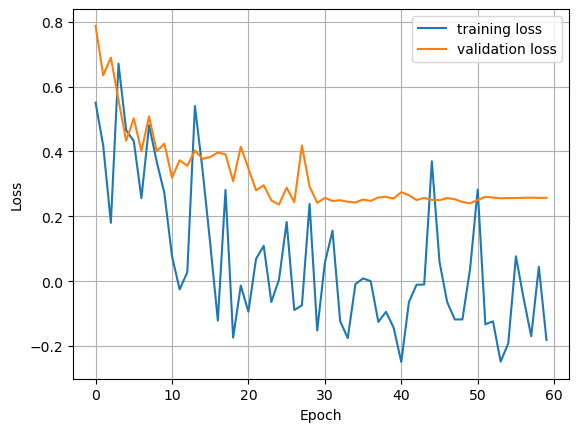

In [30]:
plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend();
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [31]:
# Rename it !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.save(Model.state_dict(), 'Modele/Big_UN1_60Epoch.pt')

In [32]:
# Model = AoRModel().to(device)
# Model.load_state_dict(torch.load('Modele/Unet_3in1out_DiceLoss_Loss001_Enc_timm-resnest50d_80Epoch_0_GoodOne.pt'))
Model.eval()

Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [33]:
inv_resize = transforms.Resize([480,640], interpolation=transforms.InterpolationMode.NEAREST)

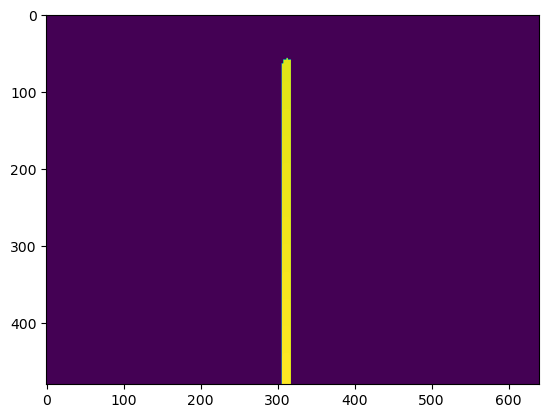

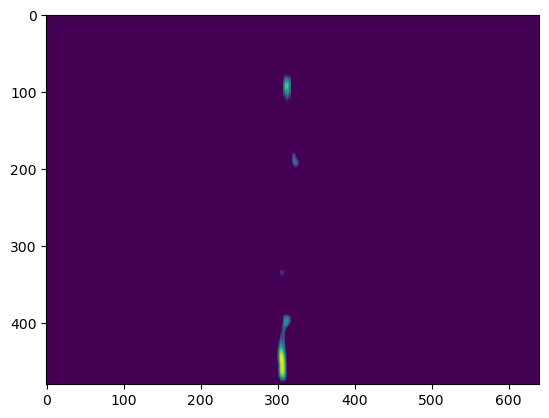

------------------------------------------------------------


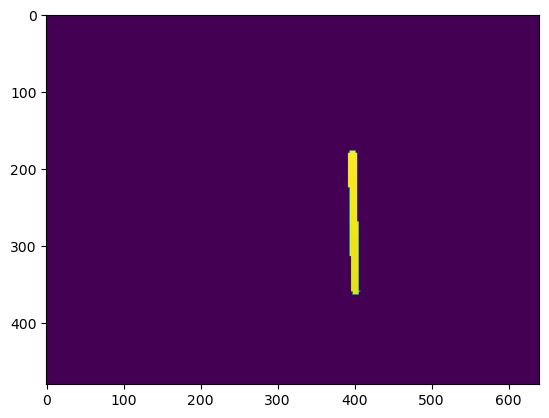

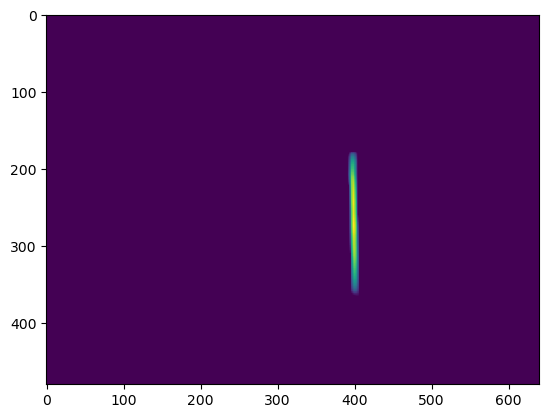

------------------------------------------------------------


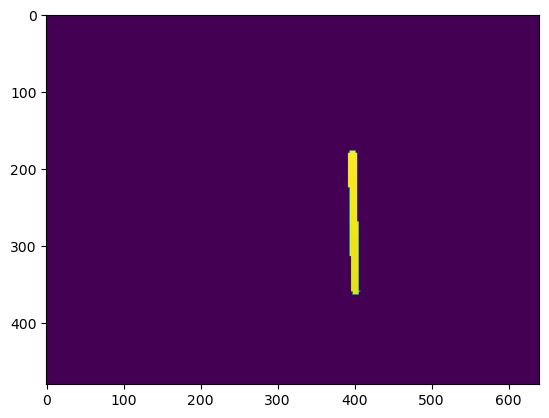

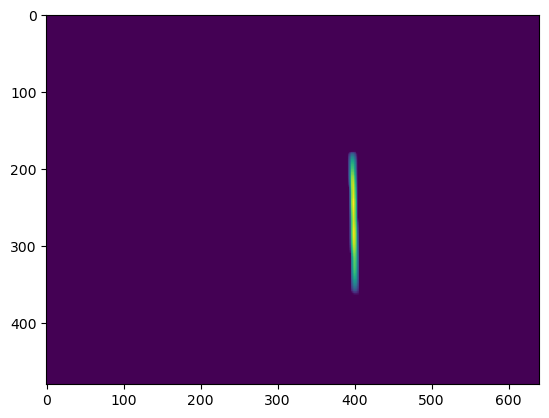

------------------------------------------------------------


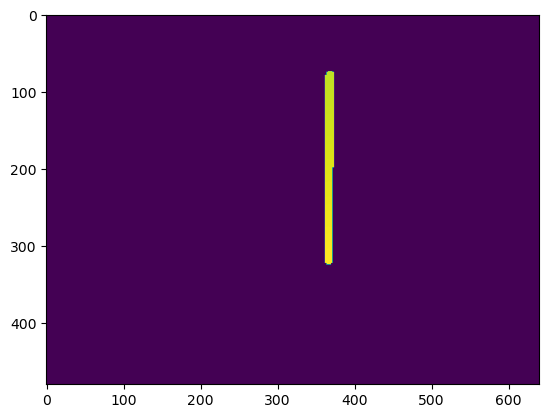

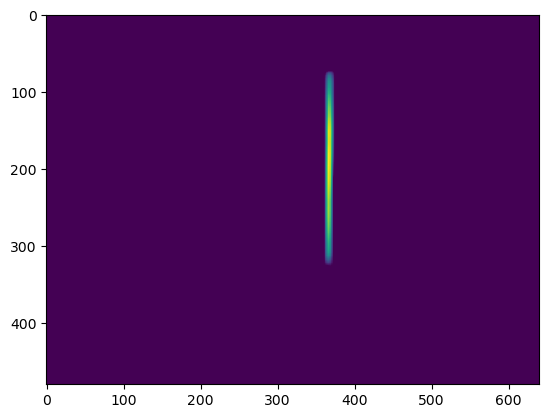

------------------------------------------------------------


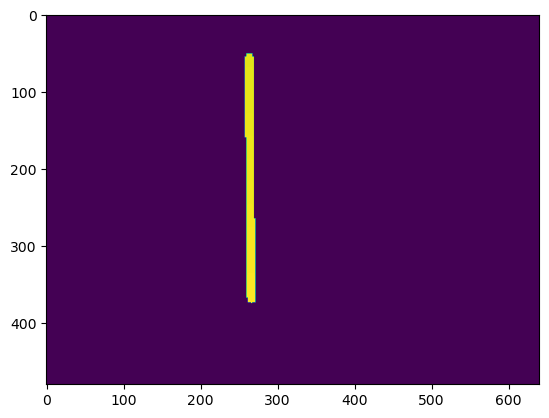

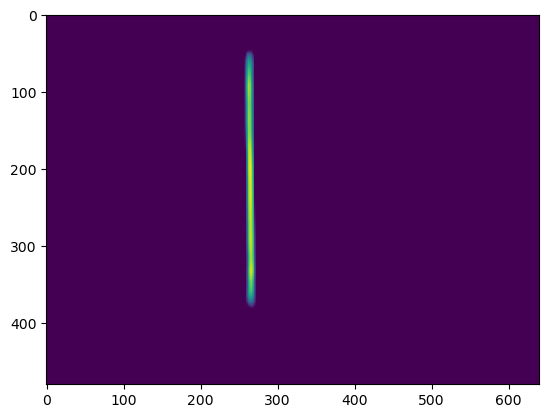

------------------------------------------------------------


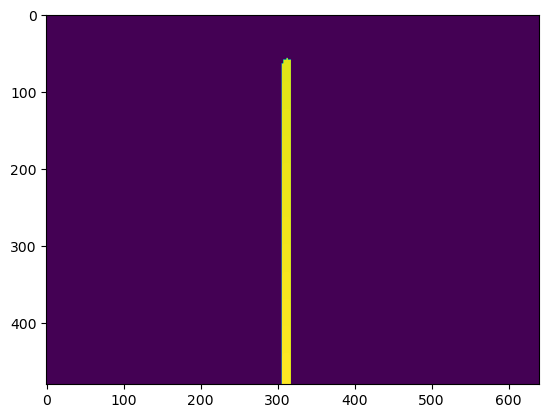

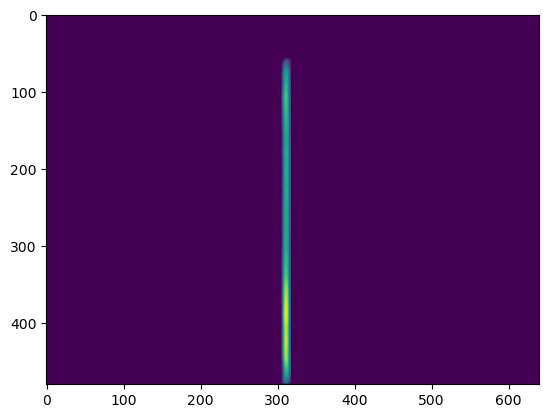

------------------------------------------------------------


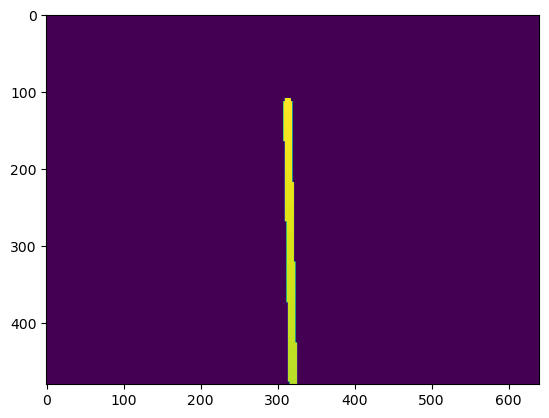

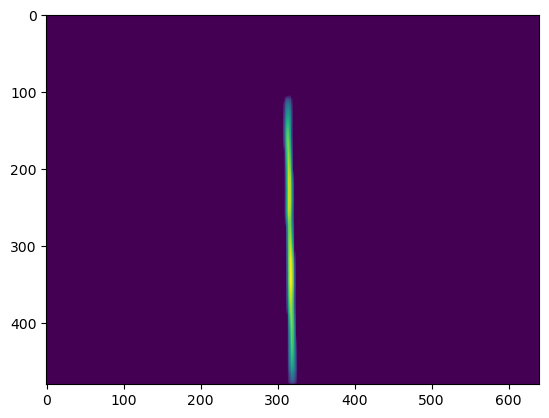

------------------------------------------------------------


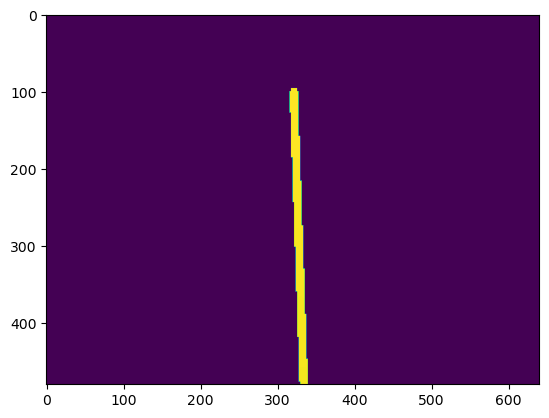

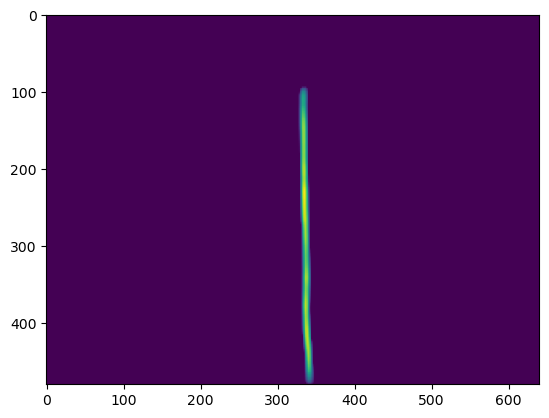

------------------------------------------------------------


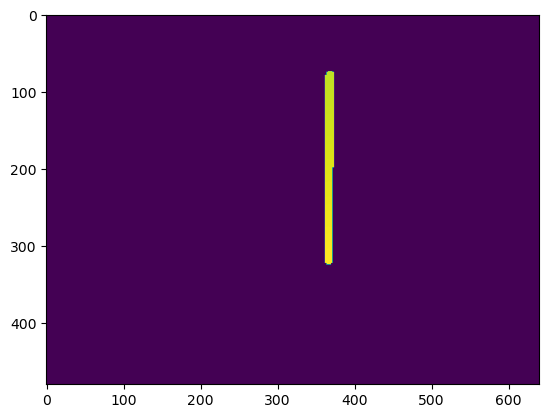

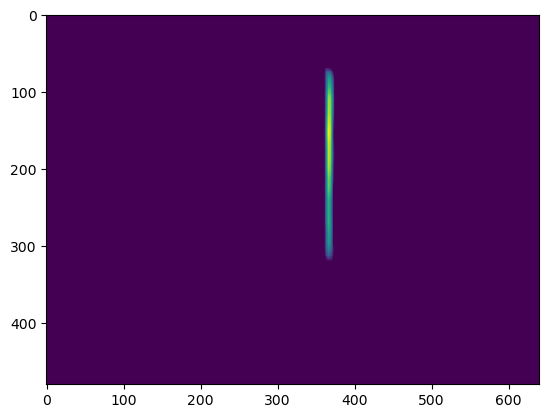

------------------------------------------------------------


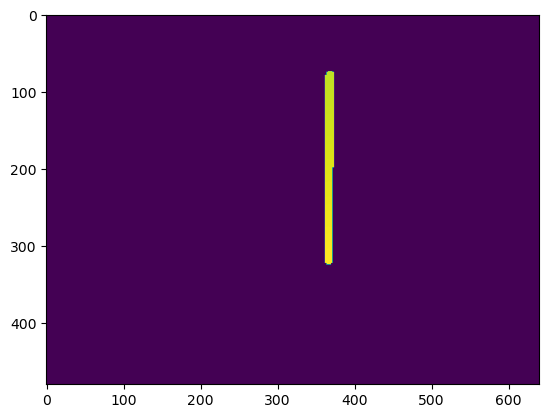

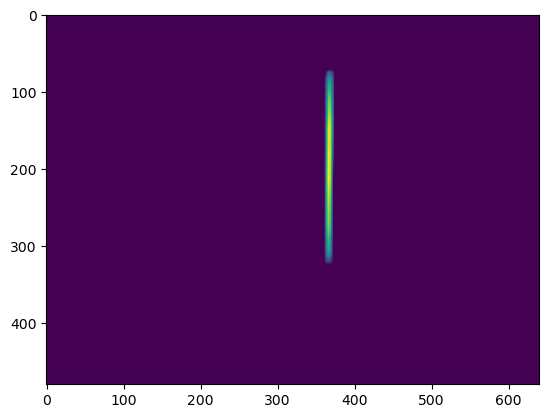

------------------------------------------------------------


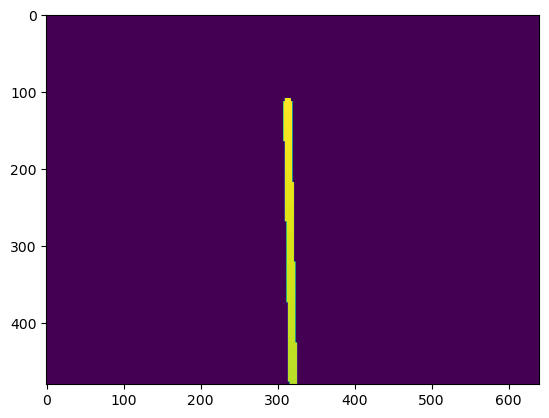

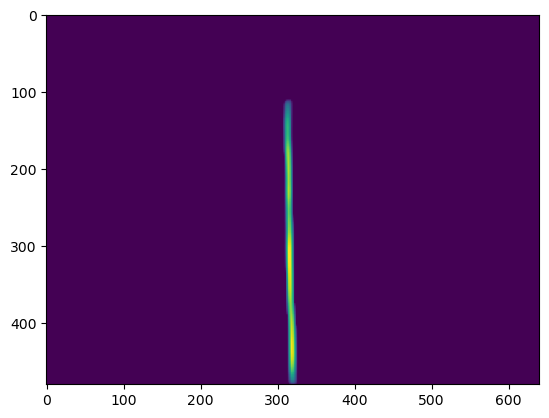

------------------------------------------------------------


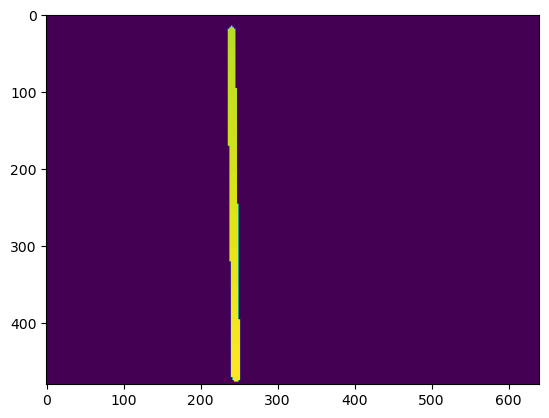

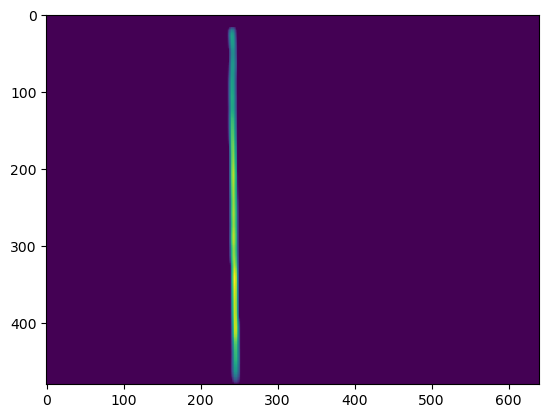

------------------------------------------------------------


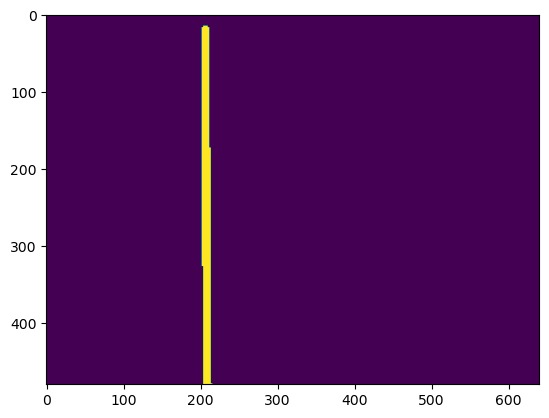

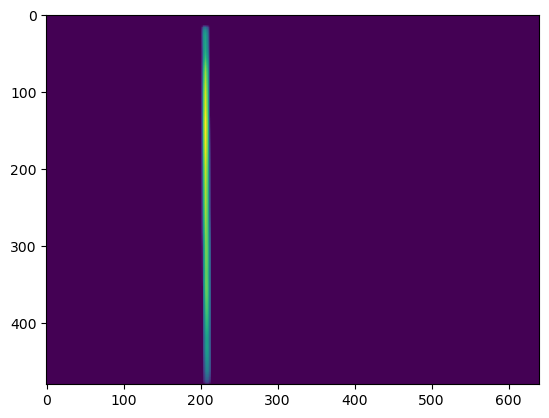

------------------------------------------------------------


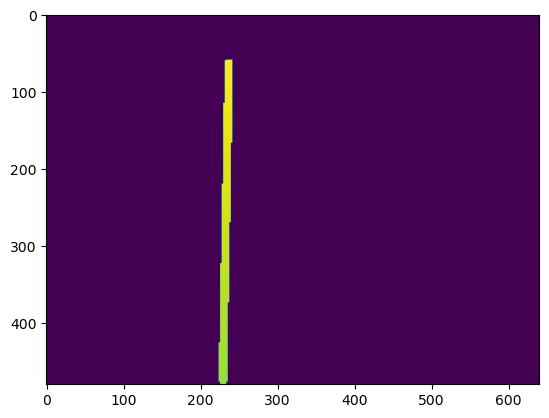

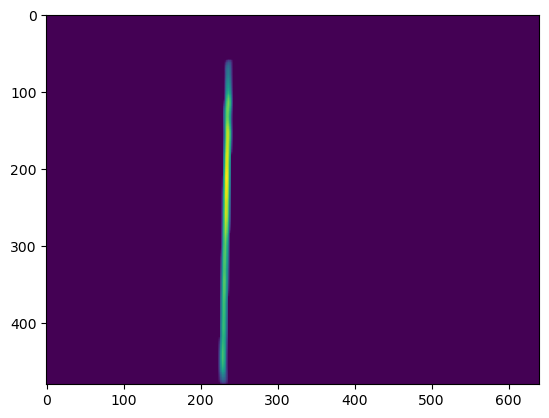

------------------------------------------------------------


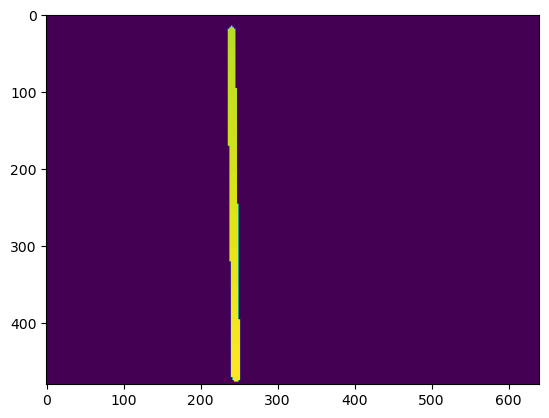

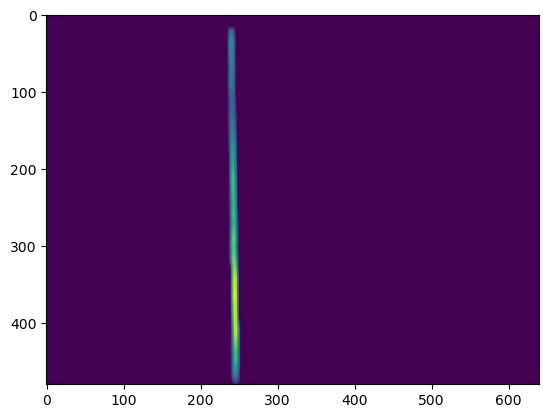

------------------------------------------------------------


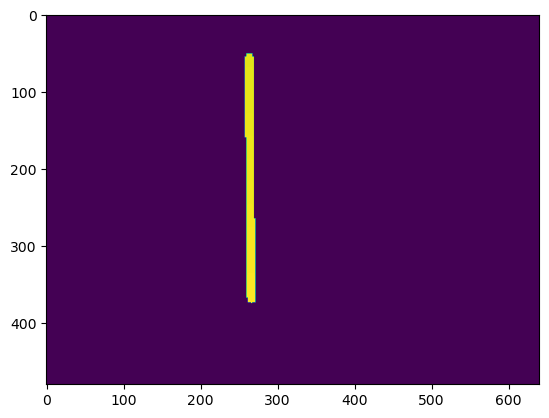

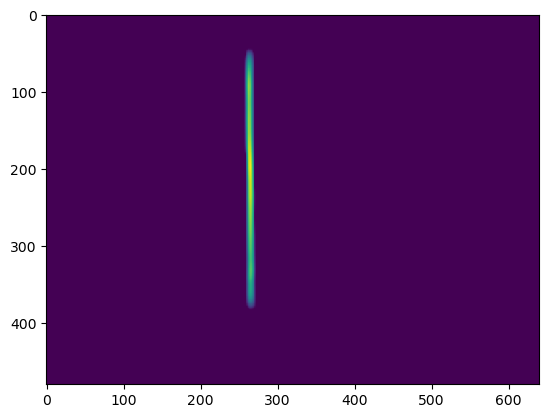

------------------------------------------------------------


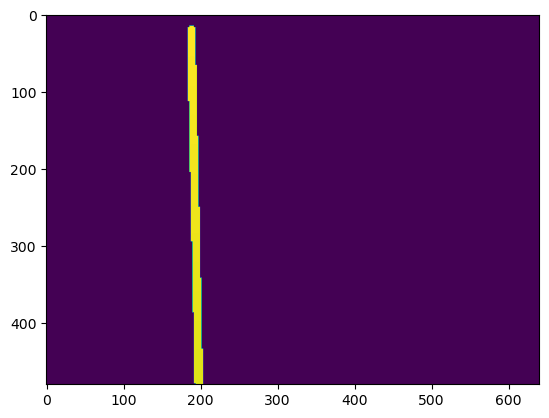

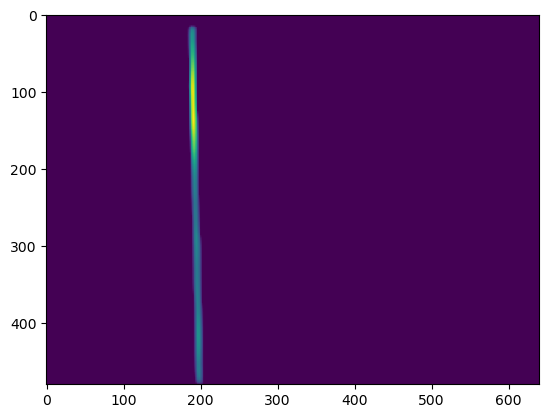

------------------------------------------------------------


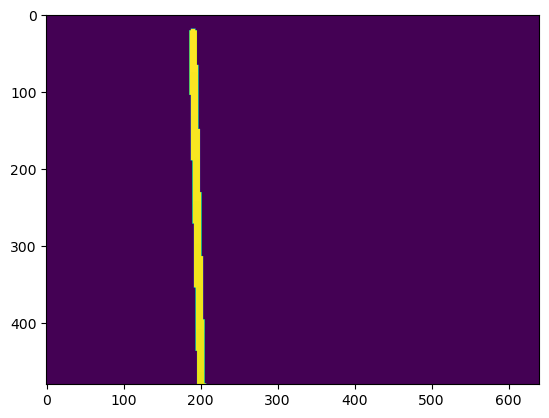

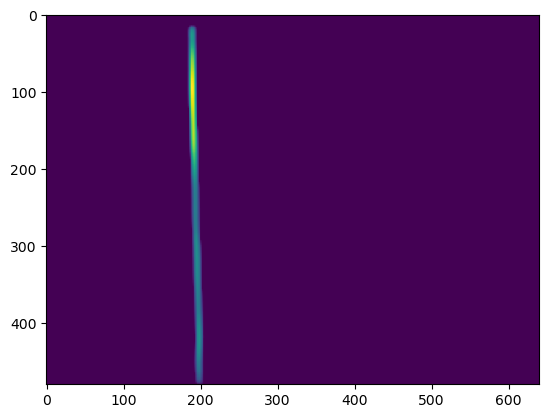

------------------------------------------------------------


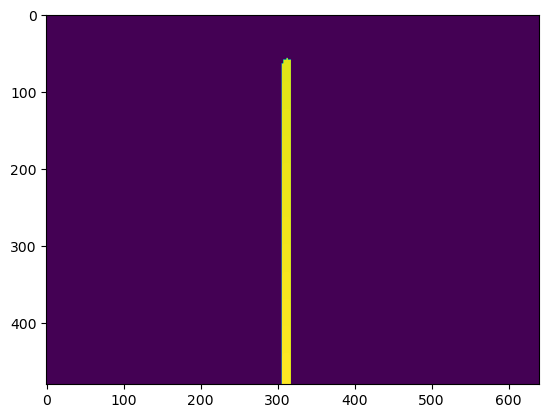

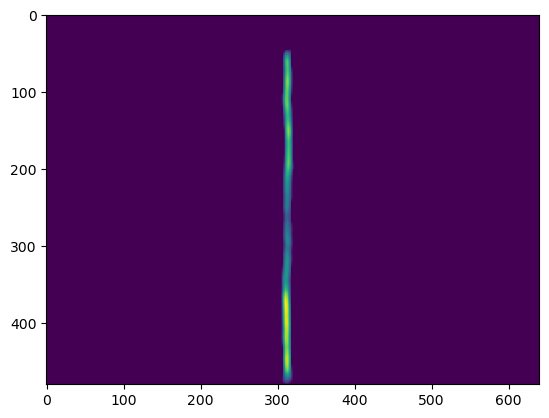

------------------------------------------------------------


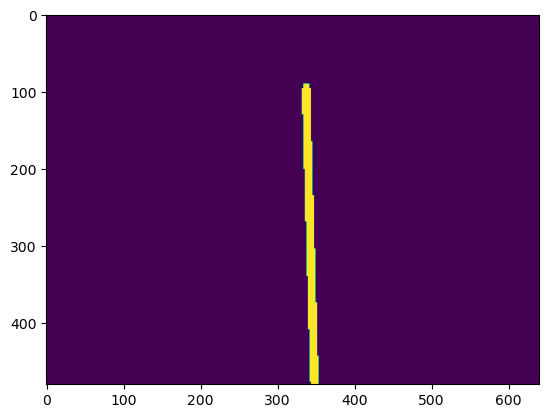

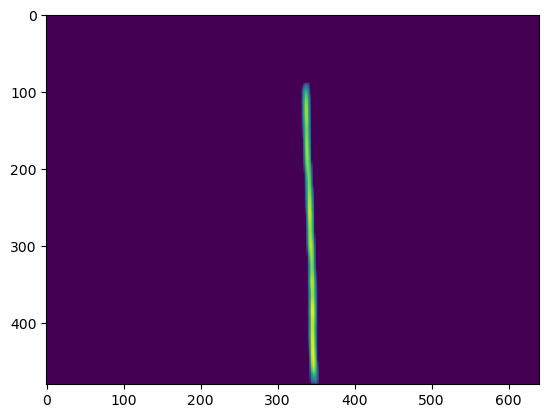

------------------------------------------------------------


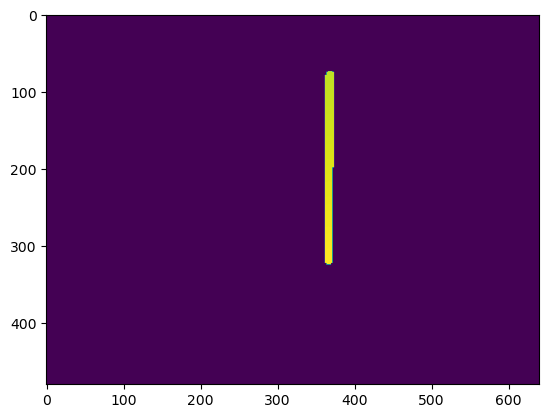

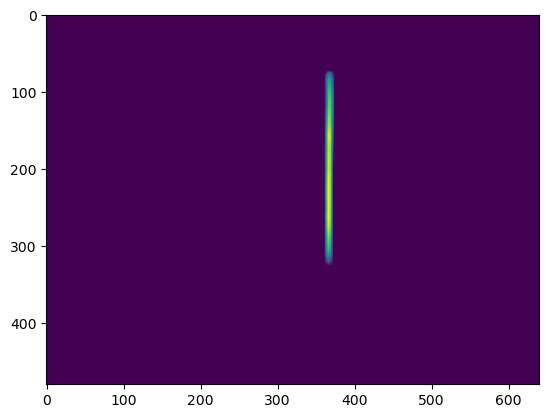

------------------------------------------------------------


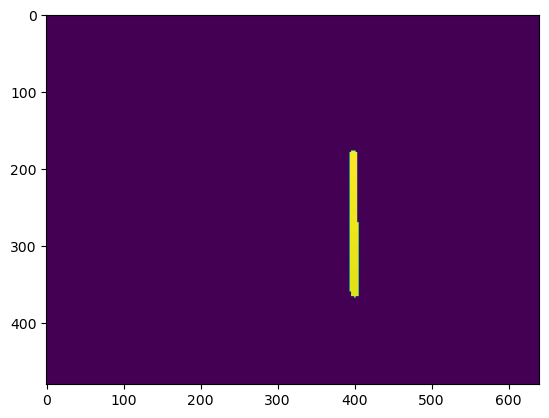

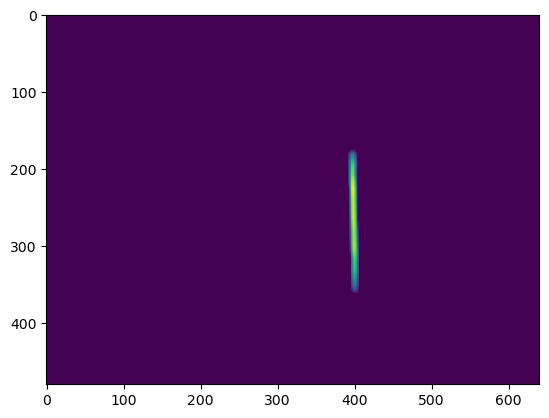

------------------------------------------------------------


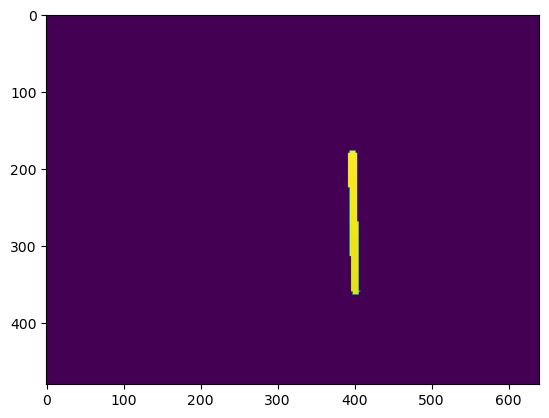

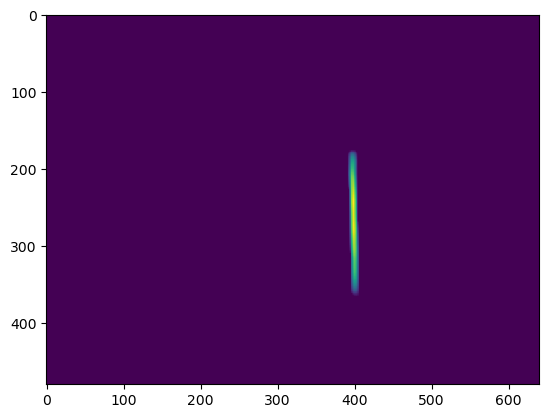

------------------------------------------------------------


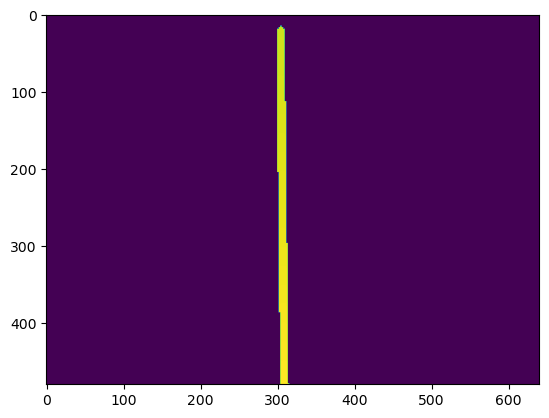

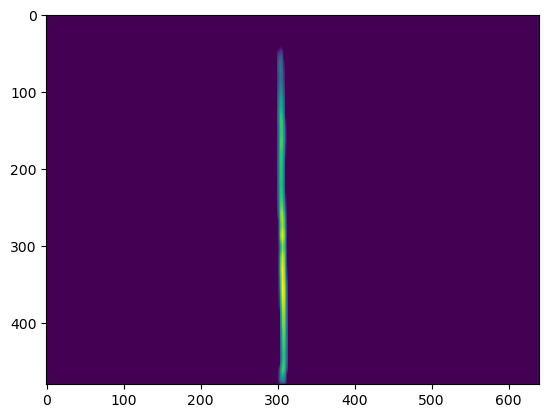

------------------------------------------------------------


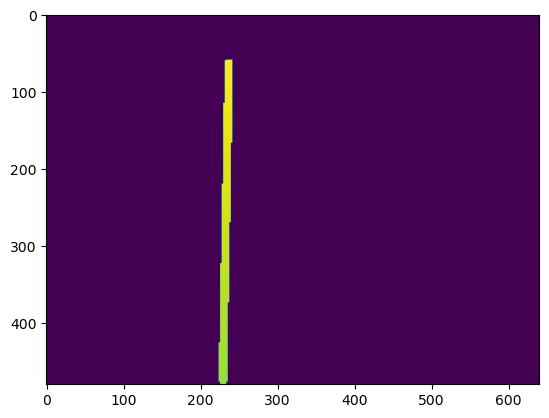

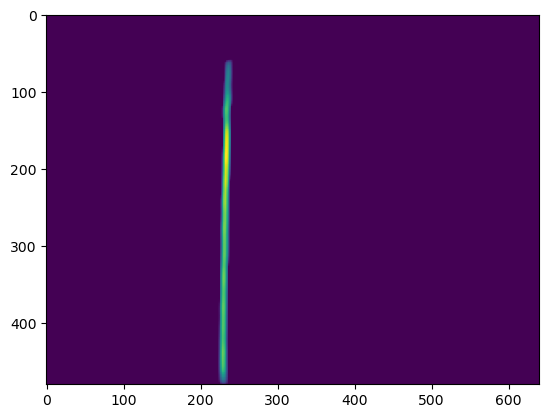

------------------------------------------------------------


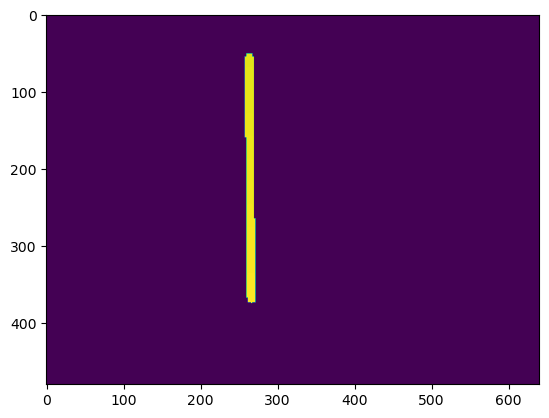

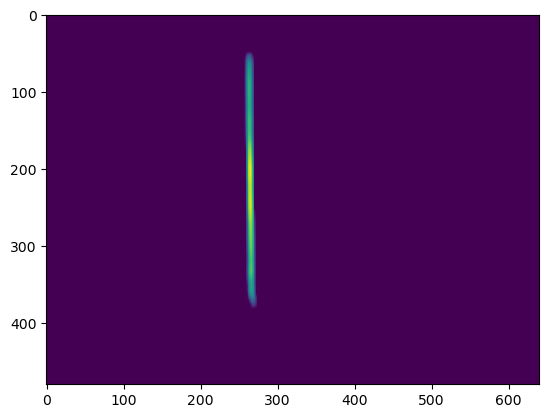

------------------------------------------------------------


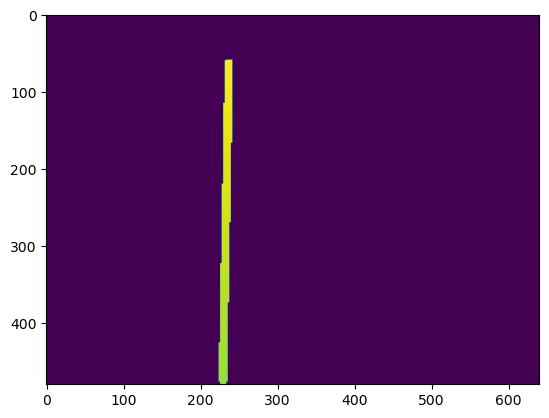

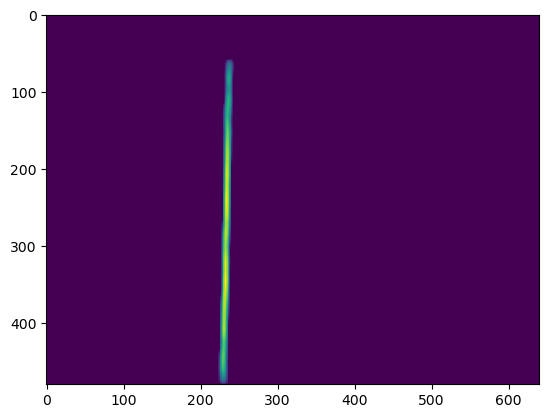

------------------------------------------------------------


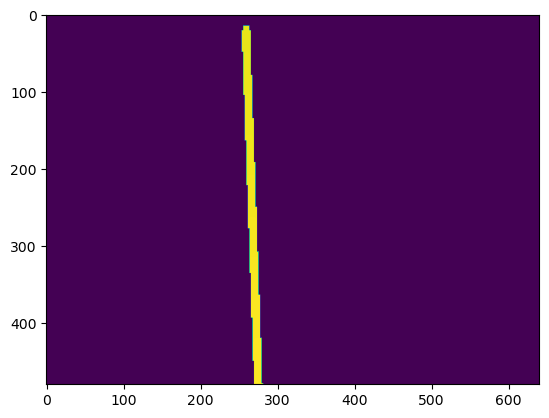

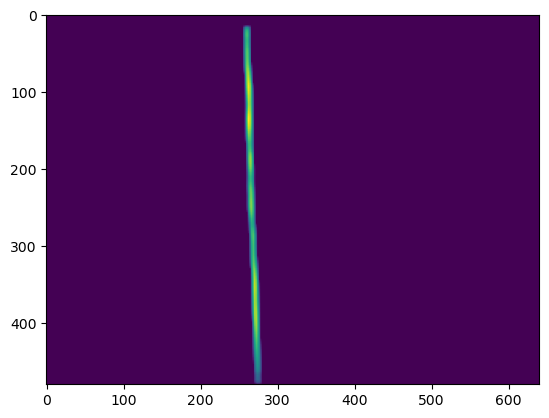

------------------------------------------------------------


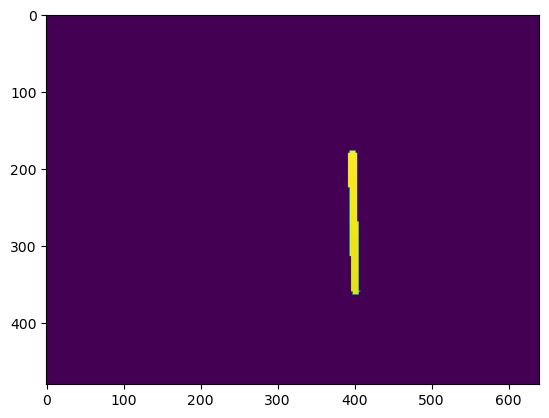

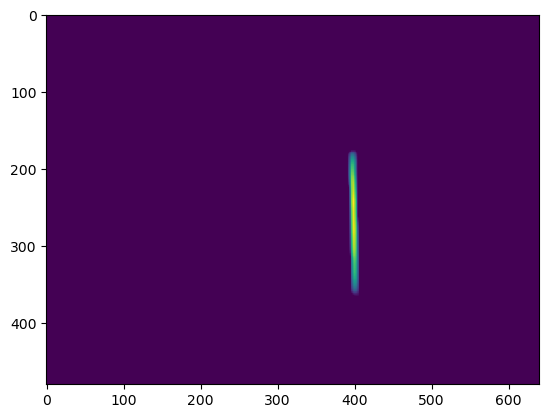

------------------------------------------------------------


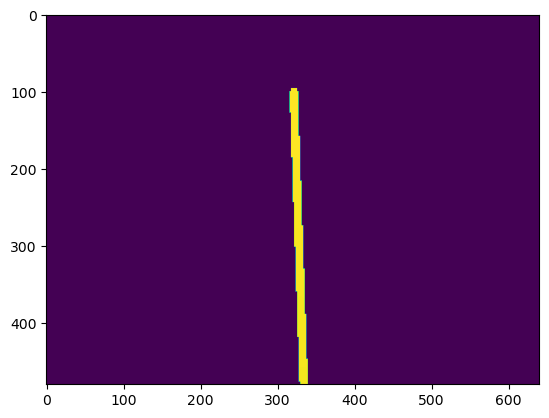

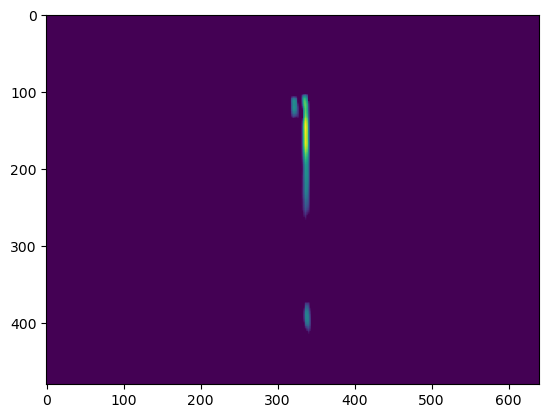

------------------------------------------------------------


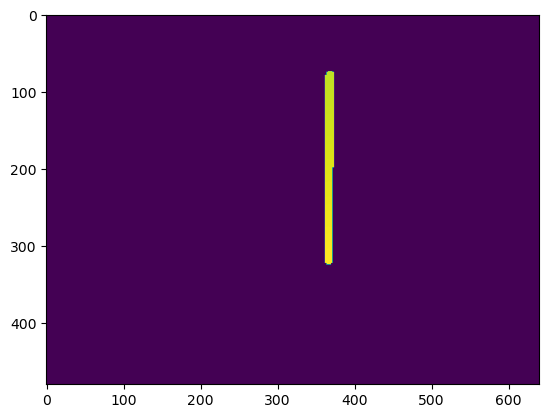

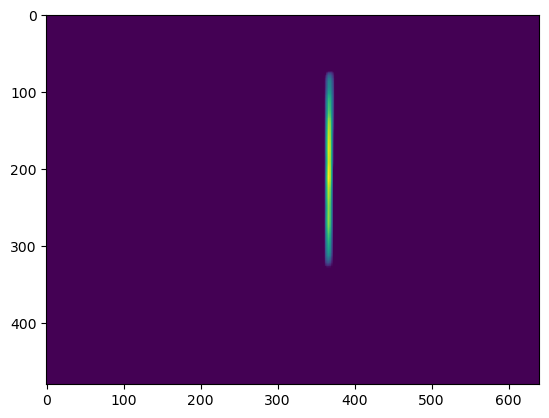

------------------------------------------------------------


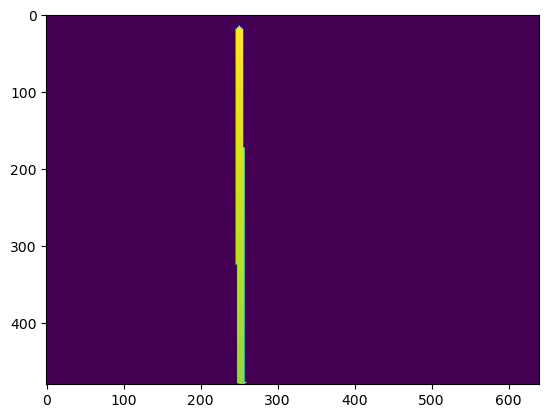

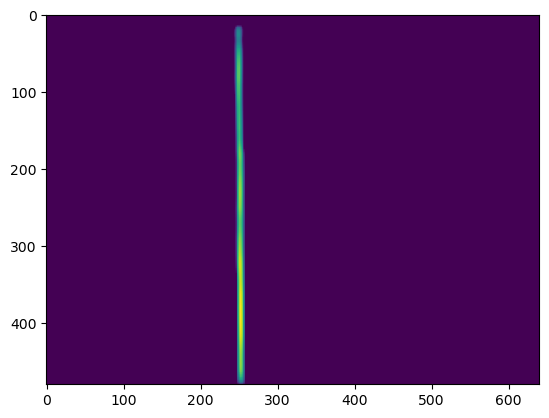

------------------------------------------------------------


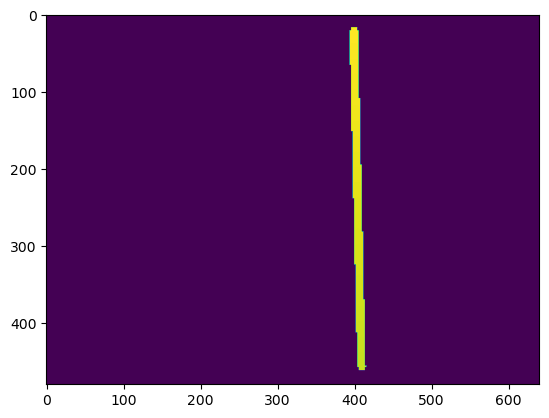

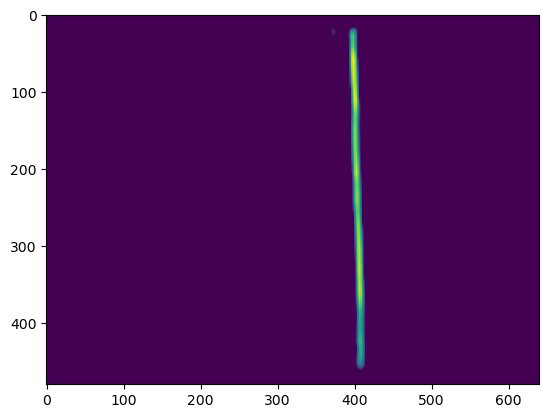

------------------------------------------------------------


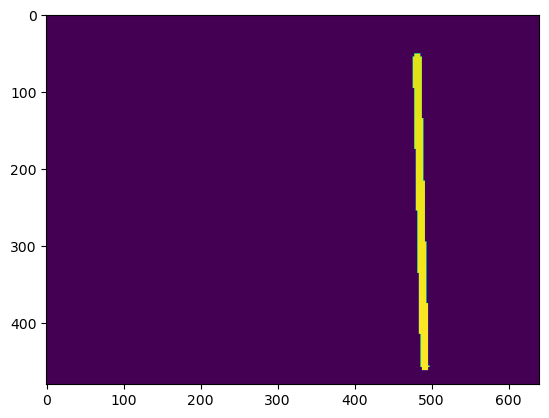

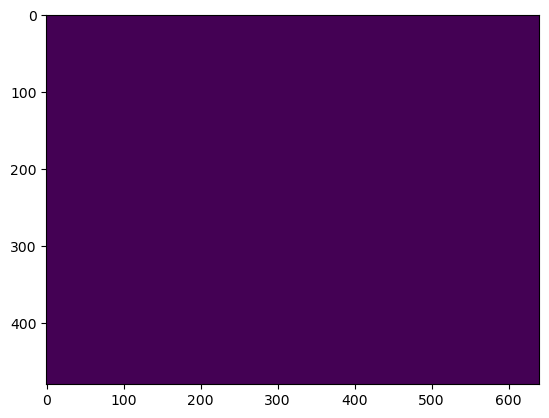

------------------------------------------------------------


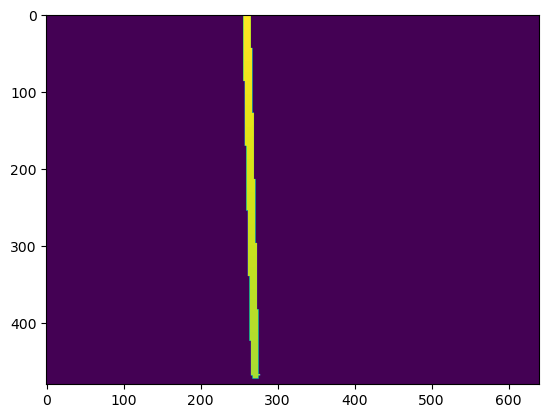

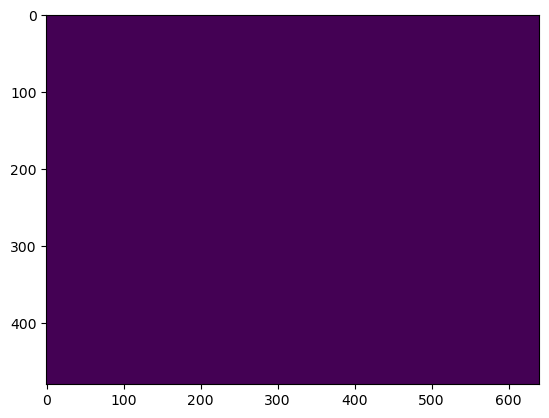

------------------------------------------------------------


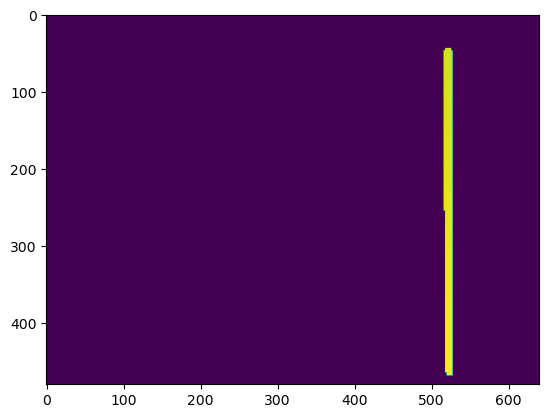

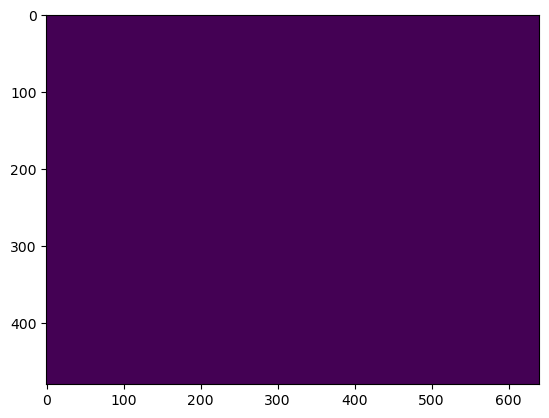

------------------------------------------------------------


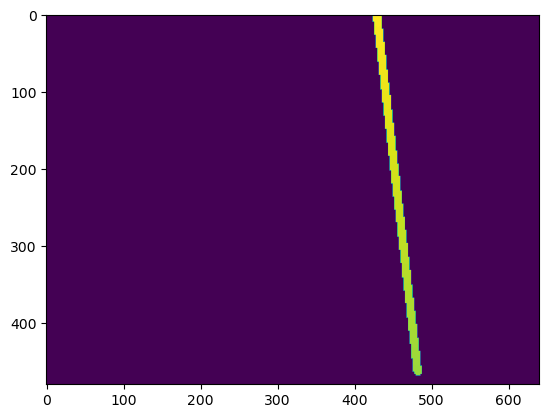

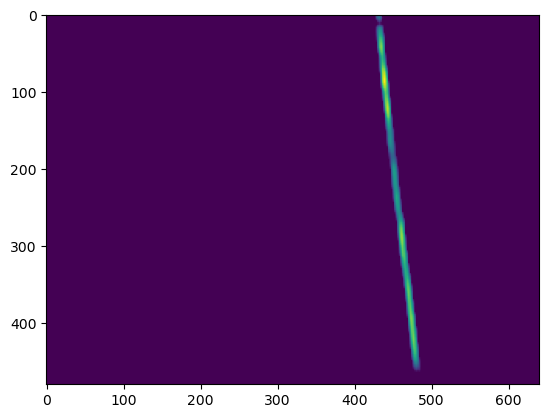

------------------------------------------------------------


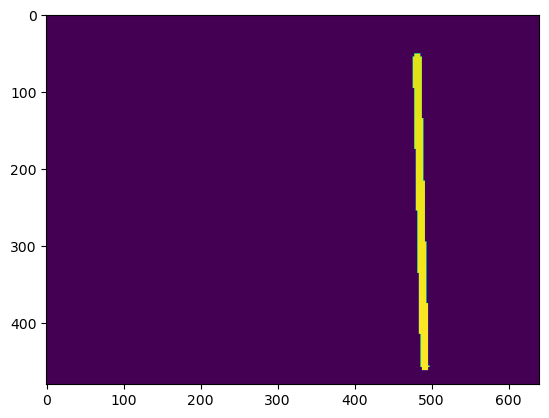

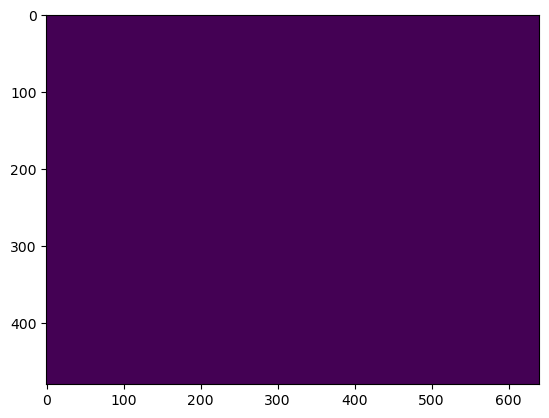

------------------------------------------------------------


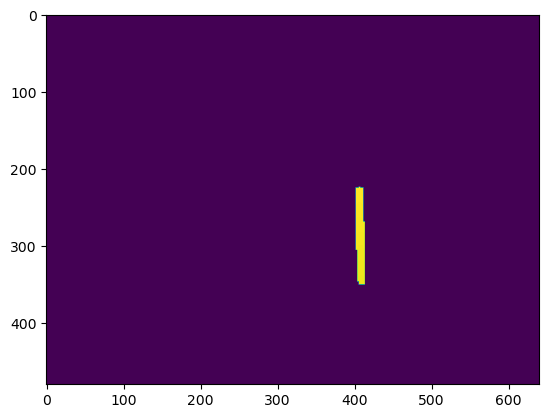

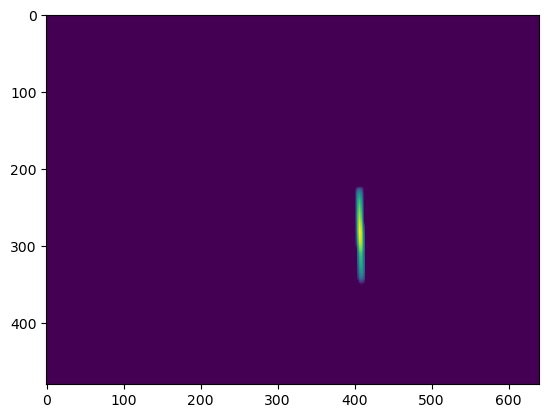

------------------------------------------------------------


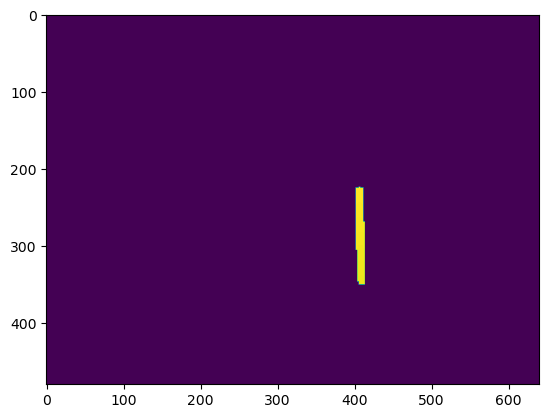

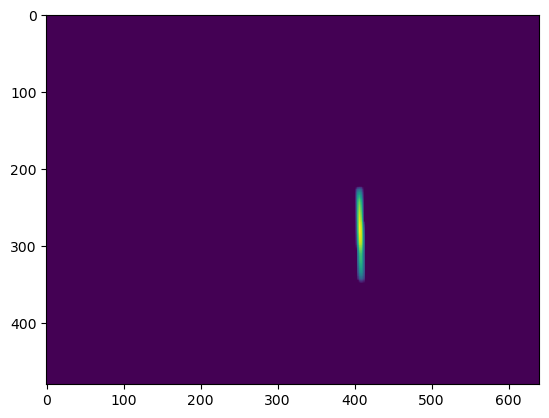

------------------------------------------------------------


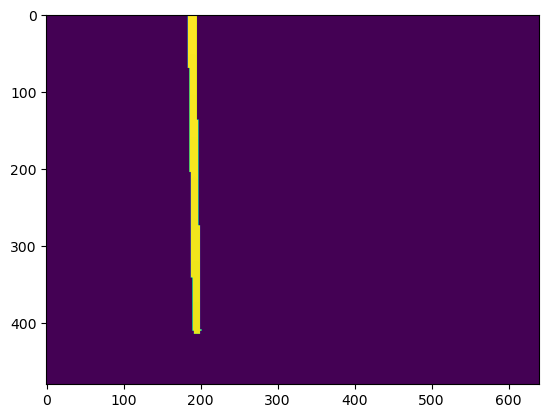

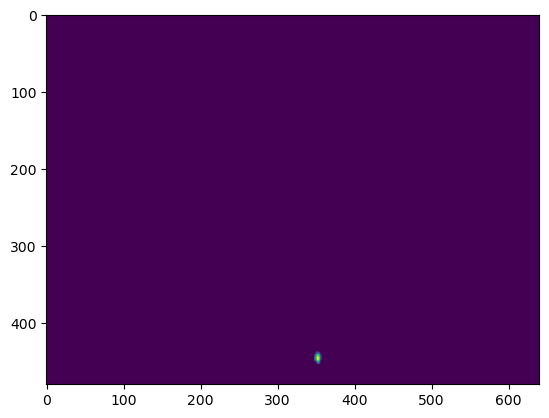

------------------------------------------------------------


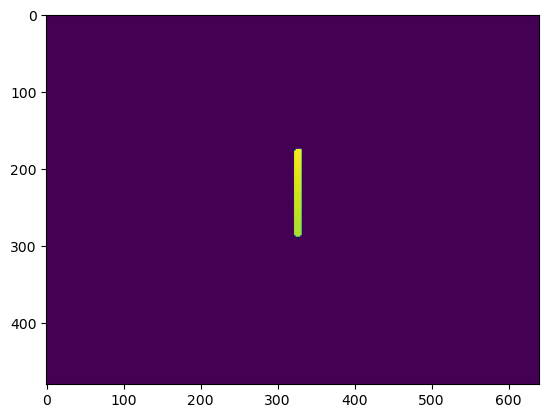

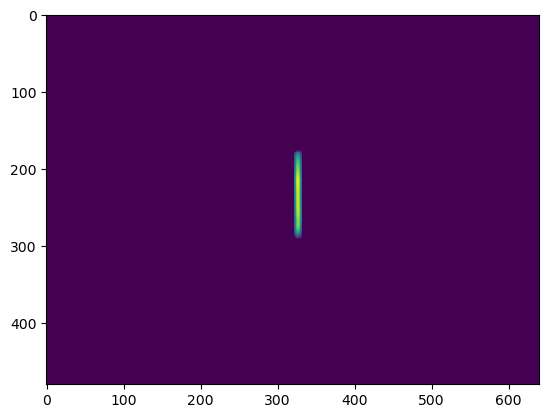

------------------------------------------------------------


In [36]:
with torch.no_grad():
    for b, (images, true_mask) in enumerate(val_loader):
#         Apply the model
        images = images.to(device=device)
        true_mask = true_mask.to(device=device)
        y_val = Model(images)
        
#         todo
#         new_input = torch.cat((images, y_val), axis=1) 
#         print(new_input.shape)
        
        y_val = F.threshold(y_val, 1, 0)
    
        
        for j in range(y_val.shape[0]):
            images_buff = inv_resize(images[j])
            RGB_buff = images_buff[0].cpu().numpy()*255
#             print(RGB_buff.shape)
#             RGB_buff = np.transpose(RGB_buff, (1,2,0))
            RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

            DEPTH_buff = images_buff[1].cpu().numpy()*5500
            trueAxis_buff = inv_resize(true_mask[j]).cpu().detach().numpy().transpose(1,2,0)
            predAxis_buff = inv_resize(y_val[j]).cpu().detach().numpy().transpose(1,2,0)
            
            NEW_DEPTH = DEPTH_buff.reshape(DEPTH_buff.shape[0],DEPTH_buff.shape[1],1)
#             new_axis = np.zeros([480,640,1])
#             new_axis[np.where(predAxis_buff > 1)] = NEW_DEPTH[np.where(predAxis_buff > 1)]
            
#             minval = np.min(new_axis[np.nonzero(new_axis)])
            
#             new_axis[np.where(predAxis_buff > 1)] = minval
#             print(minval)
            PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
            PC_realAxis = CreateAxisCloud(trueAxis_buff)
            PC_predAxis = CreateAxisCloud(predAxis_buff)
#             DrawnAxis = CreateAxisCloud(new_axis/1000)
            
#             o3d.visualization.draw_geometries([PC_object,PC_predAxis])

            plt.figure()
            plt.imshow(trueAxis_buff)
            
            plt.figure()
            plt.imshow(predAxis_buff)
            
#             plt.figure()
#             plt.imshow(new_axis)
            plt.show()
            print('------------------------------------------------------------')

# Save model

In [19]:
# Rename it !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# torch.save(Model.state_dict(), 'Modele/Large_UN_80Epoch.pt')

torch.Size([1, 1, 256, 320])


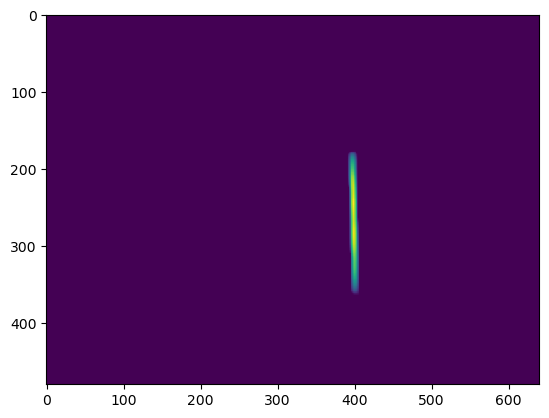

------------------------------------------------------------


In [35]:
num = 2
y = Model(X_validation[num].reshape(1,X_validation[num].shape[0],X_validation[num].shape[1],X_validation[num].shape[2]).to(device))


y = F.threshold(y, 0.2, 0)

print(y.shape)
    

images_buff = inv_resize(X_validation[5])
RGB_buff = images_buff[0].cpu().numpy()*255
RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

DEPTH_buff = images_buff[1].cpu().numpy()*5500
# trueAxis_buff = inv_resize(true_mask[j]).cpu().detach().numpy().transpose(1,2,0)
predAxis_buff = inv_resize(y[0]).cpu().detach().numpy().transpose(1,2,0)

    
NEW_DEPTH = DEPTH_buff.reshape(DEPTH_buff.shape[0],DEPTH_buff.shape[1],1)
#             new_axis = np.zeros([480,640,1])
#             new_axis[np.where(predAxis_buff > 1)] = NEW_DEPTH[np.where(predAxis_buff > 1)]
            
#             minval = np.min(new_axis[np.nonzero(new_axis)])
            
#             new_axis[np.where(predAxis_buff > 1)] = minval
#             print(minval)
PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
# PC_realAxis = CreateAxisCloud(trueAxis_buff)
PC_predAxis = CreateAxisCloud(predAxis_buff)

#             DrawnAxis = CreateAxisCloud(new_axis/1000)
            
o3d.visualization.draw_geometries([PC_object,PC_predAxis])

# plt.figure()
# plt.imshow(trueAxis_buff)
            
plt.figure()
plt.imshow(predAxis_buff)
            
#             plt.figure()
#             plt.imshow(new_axis)
plt.show()
print('------------------------------------------------------------')
